<!-- # **LMPC for Autonomous Racing**

These notes were developed by Ugo Rosolia, Charlott Vallon and Francesco Borrelli at UC Berkeley, and Luigi Glielmo at Università di Napoli Federico II. They are protected by U.S. copyright law and by University policy (https://copyright.universityofcalifornia.edu/resources/ownership-course-materials.html).

You may not reproduce, distribute or display (post/upload) lecture notes or recordings or course materials in any way — whether or not a fee is charged — without my express written consent. You also may not allow others to do so. If you do so, you may be subject to student conduct proceedings under the Berkeley Code of Student Conduct, including Sections 102.23 and 102.25. -->

In [312]:
# install required dependencies
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from numpy import linalg as la
from numpy import hstack, inf, ones
from cvxopt import spmatrix, matrix, solvers
from cvxopt.solvers import qp
from cvxopt import spmatrix, matrix, solvers
from scipy import linalg
from scipy import sparse
from scipy.sparse import vstack
import datetime
from osqp import OSQP
from dataclasses import dataclass, field

<!-- #Map

We will use a curvilinear parameterization of different race track shapes.  Given a specified track shape parameter set, we will be able to coordinate between the curvilinear reference frame to the inertial reference frame (X,Y), and vice versa.

Several maps have been hard-coded for you, but feel free to create your own! -->

In [313]:
class Map():
    """map object
    Attributes:
        getGlobalPosition: convert position from (s, ey) to (X,Y)
    """
    def __init__(self, halfWidth):
        """Initialization
        halfWidth: track halfWidth
        Modify the vector spec to change the geometry of the track
        """

        # L-shaped track
        # self.halfWidth = 0.4
        # self.slack = 0.45
        # lengthCurve = 4.5
        # spec = np.array([[1.0, 0],
        #                  [lengthCurve, lengthCurve / np.pi],
        #                  # Note s = 1 * np.pi / 2 and r = -1 ---> Angle spanned = np.pi / 2
        #                  [lengthCurve / 2, -lengthCurve / np.pi],
        #                  [lengthCurve, lengthCurve / np.pi],
        #                  [lengthCurve / np.pi * 2, 0],
        #                  [lengthCurve / 2, lengthCurve / np.pi]])

        # Alternative track shape
        # spec = np.array([[1.0, 0],
        #                  [4.5, -4.5 / np.pi],
        #                  # Note s = 1 * np.pi / 2 and r = -1 ---> Angle spanned = np.pi / 2
        #                  [2.0, 0],
        #                  [4.5, -4.5 / np.pi],
        #                  [1.0, 0]])

        # # Goggle-shaped track
        # self.slack = 0.15
        # self.halfWidth = halfWidth
        # spec = np.array([[60 * 0.03, 0],
        #                  [80 * 0.03, -80 * 0.03 * 2 / np.pi],
        #                  # Note s = 1 * np.pi / 2 and r = -1 ---> Angle spanned = np.pi / 2
        #                  [20 * 0.03, 0],
        #                  [80 * 0.03, -80 * 0.03 * 2 / np.pi],
        #                  [40 * 0.03, +40 * 0.03 * 10 / np.pi],
        #                  [60 * 0.03, -60 * 0.03 * 5 / np.pi],
        #                  [40 * 0.03, +40 * 0.03 * 10 / np.pi],
        #                  [80 * 0.03, -80 * 0.03 * 2 / np.pi],
        #                  [20 * 0.03, 0],
        #                  [80 * 0.03, -80 * 0.03 * 2 / np.pi]])

        self.halfWidth = 0.5
        self.slack = 0.35
        spec = np.array([
            [ 60 * 0.03,   0],
            [ 80 * 0.03,  +80 * 0.03 * ((12) / ( 8 * np.pi))],
            [ 20 * 0.03,   0],
            [ 20 * 0.03,   0],
            [ 40 * 0.03,  -40 * 0.03 * ((12) / ( 5 * np.pi))],
            [ 80 * 0.03,   0],
            [ 60 * 0.03,   0],
            [ 80 * 0.03,  +80 * 0.03 * ((12) / (10 * np.pi))],
            [ 40 * 0.03,   0],
            [ 60 * 0.03,  -60 * 0.03 * ((12) / ( 2 * np.pi))],
            [ 60 * 0.03,   0],
            [ 80 * 0.03,  -80 * 0.03 * ((12) / (10 * np.pi))],
            [ 20 * 0.03,   0],
            [120 * 0.03, +120 * 0.03 * ((12) / ( 9 * np.pi))],
            [ 40 * 0.03,  -40 * 0.03 * ((12) / ( 6 * np.pi))],
            [120 * 0.03, +120 * 0.03 * ((12) / ( 9 * np.pi))],
            [ 40 * 0.03,  -40 * 0.03 * ((12) / ( 6 * np.pi))],
            [160 * 0.03, +160 * 0.03 * ((12) / (11 * np.pi))],
            [ 60 * 0.03,  -60 * 0.03 * ((12) / ( 6 * np.pi))],
            [ 40 * 0.03,   0],
            [200 * 0.03, +200 * 0.03 * ((12) / (12 * np.pi))],
            [ 40 * 0.03,   0],
            [ 60 * 0.03,  -60 * 0.03 * ((12) / ( 7 * np.pi))],
            [ 80 * 0.03,   0],
            [ 40 * 0.03,  -40 * 0.03 * ((12) / ( 3 * np.pi))],
            [ 20 * 0.03,   0],
            [ 80 * 0.03,  +80 * 0.03 * ((12) / (12 * np.pi))],
            [ 40 * 0.03,   0],
            [ 60 * 0.03,  -60 * 0.03 * ((12) / ( 5 * np.pi))],
            [ 20 * 0.03,   0],
            [ 60 * 0.03,  -60 * 0.03 * ((12) / ( 6 * np.pi))],
            [ 20 * 0.03,   0],
            [160 * 0.03, +160 * 0.03 * ((12) / ( 9 * np.pi))],
            [ 80 * 0.03,   0],
        ])

        # Now given the above segments we compute the (x, y) points of the track and the angle of the tangent vector (psi) at
        # these points. For each segment we compute the (x, y, psi) coordinate at the last point of the segment. Furthermore,
        # we compute also the cumulative s at the starting point of the segment at signed curvature
        # PointAndTangent = [x, y, psi, cumulative s, segment length, signed curvature]
        PointAndTangent = np.zeros((spec.shape[0] + 1, 6))
        for i in range(0, spec.shape[0]):
            if spec[i, 1] == 0.0:              # If the current segment is a straight line
                l = spec[i, 0]                 # Length of the segments
                if i == 0:
                    ang = 0                          # Angle of the tangent vector at the starting point of the segment
                    x = 0 + l * np.cos(ang)          # x coordinate of the last point of the segment
                    y = 0 + l * np.sin(ang)          # y coordinate of the last point of the segment
                else:
                    ang = PointAndTangent[i - 1, 2]                 # Angle of the tangent vector at the starting point of the segment
                    x = PointAndTangent[i-1, 0] + l * np.cos(ang)  # x coordinate of the last point of the segment
                    y = PointAndTangent[i-1, 1] + l * np.sin(ang)  # y coordinate of the last point of the segment
                psi = ang  # Angle of the tangent vector at the last point of the segment

                if i == 0:
                    NewLine = np.array([x, y, psi, PointAndTangent[i, 3], l, 0])
                else:
                    NewLine = np.array([x, y, psi, PointAndTangent[i-1, 3] + PointAndTangent[i-1, 4], l, 0])

                PointAndTangent[i, :] = NewLine  # Write the new info
            else:
                l = spec[i, 0]                 # Length of the segment
                r = spec[i, 1]                 # Radius of curvature

                if r >= 0:
                    direction = 1
                else:
                    direction = -1

                if i == 0:
                    ang = 0                                                      # Angle of the tangent vector at the
                                                                                 # starting point of the segment
                    CenterX = 0 \
                              + np.abs(r) * np.cos(ang + direction * np.pi / 2)  # x coordinate center of circle
                    CenterY = 0 \
                              + np.abs(r) * np.sin(ang + direction * np.pi / 2)  # y coordinate center of circle
                else:
                    ang = PointAndTangent[i - 1, 2]                              # Angle of the tangent vector at the
                                                                                 # starting point of the segment
                    CenterX = PointAndTangent[i-1, 0] \
                              + np.abs(r) * np.cos(ang + direction * np.pi / 2)  # x coordinate center of circle
                    CenterY = PointAndTangent[i-1, 1] \
                              + np.abs(r) * np.sin(ang + direction * np.pi / 2)  # y coordinate center of circle

                spanAng = l / np.abs(r)  # Angle spanned by the circle
                psi = wrap(ang + spanAng * np.sign(r))  # Angle of the tangent vector at the last point of the segment

                angleNormal = wrap((direction * np.pi / 2 + ang))
                angle = -(np.pi - np.abs(angleNormal)) * (sign(angleNormal))
                x = CenterX + np.abs(r) * np.cos(
                    angle + direction * spanAng)  # x coordinate of the last point of the segment
                y = CenterY + np.abs(r) * np.sin(
                    angle + direction * spanAng)  # y coordinate of the last point of the segment

                if i == 0:
                    NewLine = np.array([x, y, psi, PointAndTangent[i, 3], l, 1 / r])
                else:
                    NewLine = np.array([x, y, psi, PointAndTangent[i-1, 3] + PointAndTangent[i-1, 4], l, 1 / r])

                PointAndTangent[i, :] = NewLine  # Write the new info

        xs = PointAndTangent[-2, 0]
        ys = PointAndTangent[-2, 1]
        xf = 0
        yf = 0
        psif = 0
        l = np.sqrt((xf - xs) ** 2 + (yf - ys) ** 2)

        NewLine = np.array([xf, yf, psif, PointAndTangent[-2, 3] + PointAndTangent[-2, 4], l, 0])
        PointAndTangent[-1, :] = NewLine

        self.PointAndTangent = PointAndTangent
        self.TrackLength = PointAndTangent[-1, 3] + PointAndTangent[-1, 4]
        
        # Friction zones: list of (s_start, s_end, mu) tuples
        # Default: uniform high friction (dry asphalt)
        # Modify this list to add ice sections
        self.friction_zones = [
            # Example: full track at mu=0.8 (dry)
            # To add ice, insert tuples like: (s_start, s_end, 0.3)
        ]
        self.default_friction = 0.8  # Default friction coefficient (dry asphalt)

    def getFriction(self, s):
        """Get friction coefficient at curvilinear position s
        Args:
            s: curvilinear abscissa position on track
        Returns:
            mu: friction coefficient at position s
        """
        # Wrap s to track length
        while s > self.TrackLength:
            s = s - self.TrackLength
        while s < 0:
            s = s + self.TrackLength
        
        # Check if s falls within any friction zone
        for s_start, s_end, mu in self.friction_zones:
            if s_start <= s < s_end:
                return mu
        
        # Return default friction if not in any special zone
        return self.default_friction

    def getGlobalPosition(self, s, ey):
        """coordinate transformation from curvilinear reference frame (e, ey) to inertial reference frame (X, Y)
        (s, ey): position in the curvilinear reference frame
        """

        # wrap s along the track
        while (s > self.TrackLength):
            s = s - self.TrackLength
        while (s < 0):
            s = s + self.TrackLength

        # Compute the segment in which system is evolving
        PointAndTangent = self.PointAndTangent

        index = np.all([[s >= PointAndTangent[:, 3]], [s < PointAndTangent[:, 3] + PointAndTangent[:, 4]]], axis=0)
        indices = np.where(np.squeeze(index))[0]
        if len(indices) == 0:
            # Edge case: s exactly at track length boundary, use last segment
            i = len(PointAndTangent) - 1
        else:
            i = int(indices[0])

        if PointAndTangent[i, 5] == 0.0:  # If segment is a straight line
            # Extract the first final and initial point of the segment
            xf = PointAndTangent[i, 0]
            yf = PointAndTangent[i, 1]
            xs = PointAndTangent[i - 1, 0]
            ys = PointAndTangent[i - 1, 1]
            psi = PointAndTangent[i, 2]

            # Compute the segment length
            deltaL = PointAndTangent[i, 4]
            reltaL = s - PointAndTangent[i, 3]

            # Do the linear combination
            x = (1 - reltaL / deltaL) * xs + reltaL / deltaL * xf + ey * np.cos(psi + np.pi / 2)
            y = (1 - reltaL / deltaL) * ys + reltaL / deltaL * yf + ey * np.sin(psi + np.pi / 2)
        else:
            r = 1 / PointAndTangent[i, 5]  # Extract curvature
            ang = PointAndTangent[i - 1, 2]  # Extract angle of the tangent at the initial point (i-1)
            # Compute the center of the arc
            if r >= 0:
                direction = 1
            else:
                direction = -1

            CenterX = PointAndTangent[i - 1, 0] \
                      + np.abs(r) * np.cos(ang + direction * np.pi / 2)  # x coordinate center of circle
            CenterY = PointAndTangent[i - 1, 1] \
                      + np.abs(r) * np.sin(ang + direction * np.pi / 2)  # y coordinate center of circle

            spanAng = (s - PointAndTangent[i, 3]) / (np.pi * np.abs(r)) * np.pi

            angleNormal = wrap((direction * np.pi / 2 + ang))
            angle = -(np.pi - np.abs(angleNormal)) * (sign(angleNormal))

            x = CenterX + (np.abs(r) - direction * ey) * np.cos(
                angle + direction * spanAng)  # x coordinate of the last point of the segment
            y = CenterY + (np.abs(r) - direction * ey) * np.sin(
                angle + direction * spanAng)  # y coordinate of the last point of the segment

        return x, y

    def getLocalPosition(self, x, y, psi):
        """coordinate transformation from inertial reference frame (X, Y) to curvilinear reference frame (s, ey)
        (X, Y): position in the inertial reference frame
        """
        PointAndTangent = self.PointAndTangent
        CompletedFlag = 0

        for i in range(0, PointAndTangent.shape[0]):
            if CompletedFlag == 1:
                break

            if PointAndTangent[i, 5] == 0.0:  # If segment is a straight line
                # Extract the first final and initial point of the segment
                xf = PointAndTangent[i, 0]
                yf = PointAndTangent[i, 1]
                xs = PointAndTangent[i - 1, 0]
                ys = PointAndTangent[i - 1, 1]

                psi_unwrap = np.unwrap([PointAndTangent[i - 1, 2], psi])[1]
                epsi = psi_unwrap - PointAndTangent[i - 1, 2]
                # Check if on the segment using angles
                if (la.norm(np.array([xs, ys]) - np.array([x, y]))) == 0:
                    s  = PointAndTangent[i, 3]
                    ey = 0
                    CompletedFlag = 1

                elif (la.norm(np.array([xf, yf]) - np.array([x, y]))) == 0:
                    s = PointAndTangent[i, 3] + PointAndTangent[i, 4]
                    ey = 0
                    CompletedFlag = 1
                else:
                    if np.abs(computeAngle( [x,y] , [xs, ys], [xf, yf])) <= np.pi/2 and np.abs(computeAngle( [x,y] , [xf, yf], [xs, ys])) <= np.pi/2:
                        v1 = np.array([x,y]) - np.array([xs, ys])
                        angle = computeAngle( [xf,yf] , [xs, ys], [x, y])
                        s_local = la.norm(v1) * np.cos(angle)
                        s       = s_local + PointAndTangent[i, 3]
                        ey      = la.norm(v1) * np.sin(angle)

                        if np.abs(ey)<= self.halfWidth + self.slack:
                            CompletedFlag = 1

            else:
                xf = PointAndTangent[i, 0]
                yf = PointAndTangent[i, 1]
                xs = PointAndTangent[i - 1, 0]
                ys = PointAndTangent[i - 1, 1]

                r = 1 / PointAndTangent[i, 5]  # Extract curvature
                if r >= 0:
                    direction = 1
                else:
                    direction = -1

                ang = PointAndTangent[i - 1, 2]  # Extract angle of the tangent at the initial point (i-1)

                # Compute the center of the arc
                CenterX = xs + np.abs(r) * np.cos(ang + direction * np.pi / 2)  # x coordinate center of circle
                CenterY = ys + np.abs(r) * np.sin(ang + direction * np.pi / 2)  # y coordinate center of circle

                # Check if on the segment using angles
                if (la.norm(np.array([xs, ys]) - np.array([x, y]))) == 0:
                    ey = 0
                    psi_unwrap = np.unwrap([ang, psi])[1]
                    epsi = psi_unwrap - ang
                    s = PointAndTangent[i, 3]
                    CompletedFlag = 1
                elif (la.norm(np.array([xf, yf]) - np.array([x, y]))) == 0:
                    s = PointAndTangent[i, 3] + PointAndTangent[i, 4]
                    ey = 0
                    psi_unwrap = np.unwrap([PointAndTangent[i, 2], psi])[1]
                    epsi = psi_unwrap - PointAndTangent[i, 2]
                    CompletedFlag = 1
                else:
                    arc1 = PointAndTangent[i, 4] * PointAndTangent[i, 5]
                    arc2 = computeAngle([xs, ys], [CenterX, CenterY], [x, y])
                    if np.sign(arc1) == np.sign(arc2) and np.abs(arc1) >= np.abs(arc2):
                        v = np.array([x, y]) - np.array([CenterX, CenterY])
                        s_local = np.abs(arc2)*np.abs(r)
                        s    = s_local + PointAndTangent[i, 3]
                        ey   = -np.sign(direction) * (la.norm(v) - np.abs(r))
                        psi_unwrap = np.unwrap([ang + arc2, psi])[1]
                        epsi = psi_unwrap - (ang + arc2)

                        if np.abs(ey) <= self.halfWidth + self.slack:
                            CompletedFlag = 1

        if CompletedFlag == 0:
            s    = 10000
            ey   = 10000
            epsi = 10000

            print("Error!! POINT OUT OF THE TRACK!!!! <==================")

        return s, ey, epsi, CompletedFlag

    def curvature(self, s):
        """curvature computation
        s: curvilinear abscissa at which the curvature has to be evaluated
        PointAndTangent: points and tangent vectors defining the map (these quantities are initialized in the map object)
        """
        TrackLength = self.PointAndTangent[-1,3]+self.PointAndTangent[-1,4]

        # In case on a lap after the first one
        while (s > TrackLength):
            s = s - TrackLength
        
        # Handle negative s values
        while (s < 0):
            s = s + TrackLength

        # Given s \in [0, TrackLength] compute the curvature
        # Compute the segment in which system is evolving
        index = np.all([[s >= self.PointAndTangent[:, 3]], [s < self.PointAndTangent[:, 3] + self.PointAndTangent[:, 4]]], axis=0)
        
        indices = np.where(np.squeeze(index))[0]
        if len(indices) == 0:
            # Edge case: s exactly at track length boundary, use last segment
            i = len(self.PointAndTangent) - 1
        else:
            i = int(indices[0])
        curvature = self.PointAndTangent[i, 5]

        return curvature

    def getAngle(self, s, epsi):
        TrackLength = self.PointAndTangent[-1,3]+self.PointAndTangent[-1,4]

        # In case on a lap after the first one
        while (s > TrackLength):
            s = s - TrackLength

        # Given s \in [0, TrackLength] compute the curvature
        # Compute the segment in which system is evolving
        index = np.all([[s >= self.PointAndTangent[:, 3]], [s < self.PointAndTangent[:, 3] + self.PointAndTangent[:, 4]]], axis=0)
        i = int(np.where(np.squeeze(index))[0])
        if i > 0:
            ang = self.PointAndTangent[i - 1, 2]
        else:
            ang = 0

        if self.PointAndTangent[i, 5] == 0:
            r= 0
        else:
            r = 1 / self.PointAndTangent[i, 5]  # Radius of curvature

        if r == 0:
            # On a straight part of the circuit
            angle_at_s = ang + epsi
        else:
            # On a curve
            cumulative_s = self.PointAndTangent[i, 3]
            relative_s = s - cumulative_s
            spanAng = relative_s / np.abs(r)  # Angle spanned by the circle
            psi = wrap(ang + spanAng * np.sign(r))  # Angle of the tangent vector at the last point of the segment
            angle_at_s = psi + epsi

        return angle_at_s


# Internal utilities functions
def computeAngle(point1, origin, point2):
    # The orientation of this angle matches that of the coordinate system. Tha is why a minus sign is needed
    v1 = np.array(point1) - np.array(origin)
    v2 = np.array(point2) - np.array(origin)

    dot = v1[0] * v2[0] + v1[1] * v2[1]  # dot product between [x1, y1] and [x2, y2]
    det = v1[0] * v2[1] - v1[1] * v2[0]  # determinant
    angle = np.arctan2(det, dot)
    return angle

def wrap(angle):
    if angle < -np.pi:
        w_angle = 2 * np.pi + angle
    elif angle > np.pi:
        w_angle = angle - 2 * np.pi
    else:
        w_angle = angle
    return w_angle

def sign(a):
    if a >= 0:
        res = 1
    else:
        res = -1
    return res

<!-- #Simulator

The simulator defines the "real" system; here, we use a dynamic bicycle model defined in the curvilinear abscessa frame. Note that our LMPC controller later will estimate a linearized version of this model using data, so $f$ and $f_{test}$ will be different! -->

In [314]:
class SIMULATOR(object):
	""" Finite Time Optimal Control Problem (FTOCP)
	Methods:
		- solve: solves the FTOCP given the initial condition x0, terminal contraints (optinal) and terminal cost (optional)
		- model: given x_t and u_t computes x_{t+1} = Ax_t + Bu_t

	"""
	def __init__(self, system, dt = 0.1,  map = []):
		# Define variables
		self.system = system
		self.dt = dt
		self.map = map

	def sim(self, x, u):
		if self.system == "dyn_bicycle_model":
			x, x_glob = self.dyn_bicycle_model(x, u)
			x_next = [x, x_glob]
		return x_next

	# Introduce function for computing road edges
	def computeRoadEdges(self, s_start, s_end, circleRadius, roadHalfWidth, signEdge = 1, disc = 1):
		edges = []
		for k in np.arange(s_start, s_end+disc, disc):#in range(s_start*disc, s_end*disc):
			angle  = k/circleRadius
			radius = circleRadius  + signEdge * roadHalfWidth
			edges.append([radius*np.sin(angle), circleRadius-radius*np.cos(angle)])
		return np.array(edges)

	# Introduce function for change of coordinates from curvilinear absicssa to XY
	def from_curvilinear_to_xy(self, xcl_feasible):
		feasibleTraj = []
		for k in range(0, np.shape(np.array(xcl_feasible))[0]):
			angle  = np.array(xcl_feasible)[k, 0]/self.radius
			radius_curr = self.radius  - np.array(xcl_feasible)[k, 1]
			feasibleTraj.append([radius_curr*np.sin(angle), self.radius-radius_curr*np.cos(angle)])
		return feasibleTraj

	def dyn_bicycle_model(self, x_states_list, u):
		# This method computes the system evolution. Note that the discretization is deltaT and therefore is needed that
		# dt <= deltaT and ( dt / deltaT) = integer value
		x = np.array(x_states_list[0])
		x_glob = np.array(x_states_list[1])

		# Vehicle Parameters
		m  = 1.98
		lf = 0.125
		lr = 0.125
		Iz = 0.024
		
		# Get position-dependent friction coefficient
		s = x[4]  # Current curvilinear position
		mu = self.map.getFriction(s)  # Query friction at current position
		
		# Tire parameters with position-dependent friction
		Df = mu * m * 9.81 / 2.0  # Peak front lateral force (friction-dependent)
		Cf = 1.25
		Bf = 1.0
		Dr = mu * m * 9.81 / 2.0  # Peak rear lateral force (friction-dependent)
		Cr = 1.25
		Br = 1.0

		# Discretization Parameters
		deltaT = 0.001
		x_next	 = np.zeros(x.shape[0])
		cur_x_next = np.zeros(x.shape[0])
		# Extract the value of the states
		delta = u[0]
		a	 = u[1]
		psi = x_glob[3]
		X = x_glob[4]
		Y = x_glob[5]
		vx	= x[0]
		vy	= x[1]
		wz	= x[2]
		epsi  = x[3]
		s	 = x[4]
		ey	= x[5]

		# Initialize counter
		i = 0
		while( (i+1) * deltaT <= self.dt):
			# Compute tire split angle
			alpha_f = delta - np.arctan2( vy + lf * wz, vx )
			alpha_r = - np.arctan2( vy - lf * wz , vx)
			# Compute lateral force at front and rear tire
			Fyf = Df * np.sin( Cf * np.arctan(Bf * alpha_f ) )
			Fyr = Dr * np.sin( Cr * np.arctan(Br * alpha_r ) )
			# Propagate the dynamics of deltaT
			x_next[0] = vx  + deltaT * (a - 1 / m * Fyf * np.sin(delta) + wz*vy)
			x_next[1] = vy  + deltaT * (1 / m * (Fyf * np.cos(delta) + Fyr) - wz * vx)
			x_next[2] = wz  + deltaT * (1 / Iz *(lf * Fyf * np.cos(delta) - lr * Fyr) )
			x_next[3] = psi + deltaT * (wz)
			x_next[4] =   X + deltaT * ((vx * np.cos(psi) - vy * np.sin(psi)))
			x_next[5] =   Y + deltaT * (vx * np.sin(psi)  + vy * np.cos(psi))

			cur = self.map.curvature(s)
			cur_x_next[0] = vx   + deltaT * (a - 1 / m * Fyf * np.sin(delta) + wz*vy)
			cur_x_next[1] = vy   + deltaT * (1 / m * (Fyf * np.cos(delta) + Fyr) - wz * vx)
			cur_x_next[2] = wz   + deltaT * (1 / Iz *(lf * Fyf * np.cos(delta) - lr * Fyr) )
			cur_x_next[3] = epsi + deltaT * ( wz - (vx * np.cos(epsi) - vy * np.sin(epsi)) / (1 - cur * ey) * cur )
			cur_x_next[4] = s	+ deltaT * ( (vx * np.cos(epsi) - vy * np.sin(epsi)) / (1 - cur * ey) )
			cur_x_next[5] = ey   + deltaT * (vx * np.sin(epsi) + vy * np.cos(epsi))

			# Update the value of the states
			psi  = x_next[3]
			X	= x_next[4]
			Y	= x_next[5]
			vx   = cur_x_next[0]
			vy   = cur_x_next[1]
			wz   = cur_x_next[2]
			epsi = cur_x_next[3]
			s	= cur_x_next[4]
			ey   = cur_x_next[5]

			# Increment counter
			i = i+1

		# Noises
		noise_vx = np.max([-0.05, np.min([np.random.randn() * 0.01, 0.05])])
		noise_vy = np.max([-0.05, np.min([np.random.randn() * 0.01, 0.05])])
		noise_wz = np.max([-0.05, np.min([np.random.randn() * 0.005, 0.05])])

		cur_x_next[0] = cur_x_next[0] + 0.01*noise_vx
		cur_x_next[1] = cur_x_next[1] + 0.01*noise_vy
		cur_x_next[2] = cur_x_next[2] + 0.01*noise_wz

		return cur_x_next.tolist(), x_next.tolist()

		# x_next[0] = x_next[0] + 0.01*noise_vx

		# x_next[1] = x_next[1] + 0.01*noise_vy		x_next[2] = x_next[2] + 0.01*noise_wz

<!-- # First Lap
We will begin by finding a sub-optimal, but feasible, state and input trajectory with which to initialize our LMPC controller later. Here we use a PID controller that will track the centerline of the track. -->

In [315]:
class PID:
    """
    Create the PID controller used for path following at constant speed
    Attributes:
        solve: given x0 computes the control action
    """
    def __init__(self, vt):
        """Initialization
        Arguments:
            vt: target velocity
        """
        self.vt = vt
        self.uPred = np.zeros([2,1])

        startTimer = datetime.datetime.now()
        endTimer = datetime.datetime.now(); deltaTimer = endTimer - startTimer
        self.solverTime = deltaTimer
        self.linearizationTime = deltaTimer
        self.feasible = 1

    def solve(self, x0):
        """Computes control action
        Arguments:
            x0: current state position
        """
        vt = self.vt
        self.uPred[0, 0] = - 0.6 * x0[5] - 0.9 * x0[3] + np.max([-0.9, np.min([np.random.randn() * 0.25, 0.9])])
        self.uPred[1, 0] = 1.5 * (vt - x0[0]) + np.max([-0.2, np.min([np.random.randn() * 0.10, 0.2])])


In [316]:
# ======================================================================================================================
# ============================================= Test Configuration =====================================================
# ======================================================================================================================
# Select test: 1 = Baseline (no ice), 2 = Surprise Ice (ice added at lap 10)
TEST_MODE = 2  # Change to 2 for surprise ice test

# Ice configuration for test 2
ICE_ZONE = [(30, 60, 0.2)]  # (s_start, s_end, mu)
ICE_LAP = 15                # Lap when ice appears

print(f"Test Mode: {'Baseline' if TEST_MODE == 1 else 'Surprise Ice'}")

# ======================================================================================================================
# ============================================= Initialize parameters  =================================================
# ======================================================================================================================
x0 = [0.5, 0, 0, 0, 0, 0]                 # Initial condition
dt = 0.1

map = Map(0.4)                            # Initialize map

# ======================================================================================================================
# ================================= Configure Ice/Friction Zones BEFORE PID ============================================
# ======================================================================================================================
# For both tests, PID runs on clean track (no ice zones initially)
map.friction_zones = []

print(f"Track Length: {map.TrackLength:.2f} meters")
print(f"PID will run on clean track (no ice)")

vt = 0.8                                  # target velocity

simulator = SIMULATOR("dyn_bicycle_model", map=map, dt=0.1) # Init simulators

# ======================================================================================================================
# ======================================= PID path following ===========================================================
# ======================================================================================================================
print("\nStarting PID")
# Initialize pid and run sim
PIDController = PID(vt)
t_max = 3000

xcl_pid = [x0]
xcl_pid_glob = [x0]
ucl_pid = []

for time in range(t_max):
    # read measurement
    xt = xcl_pid[time]

    # Solve LMPC
    PIDController.solve(xt)

    # Apply input and store closed-loop data
    ut = PIDController.uPred[:,0]
    ucl_pid.append(ut.tolist())
    x_next = simulator.sim([xcl_pid[time], xcl_pid_glob[time]], ut) # Simulate both in global and local coordinates
    xcl_pid.append(x_next[0])
    xcl_pid_glob.append(x_next[1])

    # increment time counter
    time += 1

print(f"PID completed: {len(ucl_pid)} timesteps")

Test Mode: Surprise Ice
Track Length: 67.46 meters
PID will run on clean track (no ice)

Starting PID
PID completed: 3000 timesteps


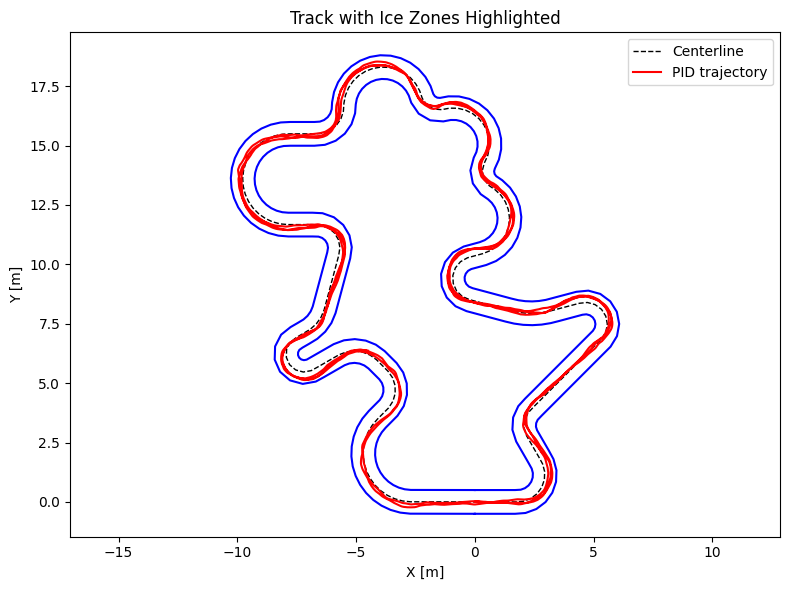

In [317]:
# ======================================================================================================================
# ================================= Visualize PID Trajectory with Ice Zones ============================================
# ======================================================================================================================
import matplotlib.pyplot as plt

xcl_pid_glob_arr = np.array(xcl_pid_glob)

fig, ax = plt.subplots(figsize=(8, 6))

# Plot track boundaries
track_s = np.linspace(0, map.TrackLength, 200)
inner_x, inner_y, outer_x, outer_y, center_x, center_y = [], [], [], [], [], []
for s in track_s:
    x_c, y_c = map.getGlobalPosition(s, 0)
    x_in, y_in = map.getGlobalPosition(s, -map.halfWidth)
    x_out, y_out = map.getGlobalPosition(s, map.halfWidth)
    center_x.append(x_c); center_y.append(y_c)
    inner_x.append(x_in); inner_y.append(y_in)
    outer_x.append(x_out); outer_y.append(y_out)

ax.plot(inner_x, inner_y, 'b-', linewidth=1.5)
ax.plot(outer_x, outer_y, 'b-', linewidth=1.5)
ax.plot(center_x, center_y, 'k--', linewidth=1, label='Centerline')

# Highlight ice zones on track
for s_start, s_end, mu in map.friction_zones:
    ice_s = np.linspace(s_start, s_end, 50)
    ice_inner_x, ice_inner_y, ice_outer_x, ice_outer_y = [], [], [], []
    for s in ice_s:
        x_in, y_in = map.getGlobalPosition(s, -map.halfWidth)
        x_out, y_out = map.getGlobalPosition(s, map.halfWidth)
        ice_inner_x.append(x_in); ice_inner_y.append(y_in)
        ice_outer_x.append(x_out); ice_outer_y.append(y_out)
    ax.fill(ice_inner_x + ice_outer_x[::-1], ice_inner_y + ice_outer_y[::-1], 
            color='cyan', alpha=0.5, label=f'Ice zone (μ={mu})')

# Plot trajectory
ax.plot(xcl_pid_glob_arr[:, 4], xcl_pid_glob_arr[:, 5], 'r-', linewidth=1.5, label='PID trajectory')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title('Track with Ice Zones Highlighted')
ax.axis('equal')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

<!-- # LMPC Code -->

In [318]:
@dataclass
class PythonMsg:
    def __setattr__(self,key,value):
        if not hasattr(self,key):
            raise TypeError ('Cannot add new field "%s" to frozen class %s' %(key,self))
        else:
            object.__setattr__(self,key,value)

@dataclass
class MPCParams(PythonMsg):
    n: int = field(default=None) # dimension state space
    d: int = field(default=None) # dimension input space
    N: int = field(default=None) # horizon length

    A: np.array = field(default=None) # prediction matrices. Single matrix for LTI and list for LTV
    B: np.array = field(default=None) # prediction matrices. Single matrix for LTI and list for LTV

    #Q: np.array = field(default=np.array((n, n))) # quadratic state cost
    Q: np.array = field(default=None) # quadratic state cost
    R: np.array = field(default=None) # quadratic input cost
    Qf: np.array = field(default=None) # quadratic state cost final
    dR: np.array = field(default=None) # Quadratic rate cost

    Qslack: float = field(default=None) # it has to be a vector. Qslack = [linearSlackCost, quadraticSlackCost]
    Fx: np.array = field(default=None) # State constraint Fx * x <= bx
    bx: np.array = field(default=None)
    Fu: np.array = field(default=None) # State constraint Fu * u <= bu
    bu: np.array = field(default=None)
    xRef: np.array = field(default=None)

    slacks: bool = field(default=True)
    timeVarying: bool = field(default=False)

    def __post_init__(self):
        if self.Qf is None: self.Qf = np.zeros((self.n, self.n))
        if self.dR is None: self.dR = np.zeros(self.d)
        if self.xRef is None: self.xRef = np.zeros(self.n)

# MPC
class MPC():
    """Model Predicitve Controller class
    Methods (needed by user):
        solve: given system's state xt compute control action at
    Arguments:
        mpcParameters: model paramters
    """
    def __init__(self,  mpcParameters, predictiveModel=[]):
        """Initialization
        Arguments:
            mpcParameters: struct containing MPC parameters
        """
        self.N      = mpcParameters.N
        self.Qslack = mpcParameters.Qslack
        self.Q      = mpcParameters.Q
        self.Qf     = mpcParameters.Qf
        self.R      = mpcParameters.R
        self.dR     = mpcParameters.dR
        self.n      = mpcParameters.n
        self.d      = mpcParameters.d
        self.A      = mpcParameters.A
        self.B      = mpcParameters.B
        self.Fx     = mpcParameters.Fx
        self.Fu     = mpcParameters.Fu
        self.bx     = mpcParameters.bx
        self.bu     = mpcParameters.bu
        self.xRef   = mpcParameters.xRef

        self.slacks          = mpcParameters.slacks
        self.timeVarying     = mpcParameters.timeVarying
        self.predictiveModel = predictiveModel

        if self.timeVarying == True:
            self.xLin = self.predictiveModel.xStored[-1][0:self.N+1,:]
            self.uLin = self.predictiveModel.uStored[-1][0:self.N,:]
            self.computeLTVdynamics()
        self.OldInput = np.zeros((1,2))
        # Build matrices for inequality constraints
        self.buildIneqConstr()
        self.buildCost()
        self.buildEqConstr()
        self.xPred = []
        # initialize time
        startTimer = datetime.datetime.now()
        endTimer = datetime.datetime.now(); deltaTimer = endTimer - startTimer
        self.solverTime = deltaTimer
        self.linearizationTime = deltaTimer
        self.timeStep = 0

    def solve(self, x0):
        """Computes control action
        Arguments:
            x0: current state
        """
        # If LTV active --> identify system model
        if self.timeVarying == True:
            self.computeLTVdynamics()
            self.buildCost()
            self.buildEqConstr()
        self.addTerminalComponents(x0)
        # Solve QP
        startTimer = datetime.datetime.now()
        self.osqp_solve_qp(self.H_FTOCP, self.q_FTOCP, self.F_FTOCP, self.b_FTOCP, self.G_FTOCP, np.add(np.dot(self.E_FTOCP,x0),self.L_FTOCP))
        self.unpackSolution()
        endTimer = datetime.datetime.now(); deltaTimer = endTimer - startTimer
        self.solverTime = deltaTimer
        # If LTV active --> compute state-input linearization trajectory
        self.feasibleStateInput()
        if self.timeVarying == True:
            self.xLin = np.vstack((self.xPred[1:, :], self.zt))
            self.uLin = np.vstack((self.uPred[1:, :], self.zt_u))
        # update applied input
        self.OldInput = self.uPred[0,:]
        self.timeStep += 1

    def computeLTVdynamics(self):
        # Estimate system dynamics with friction horizon lookup
        self.A = []; self.B = []; self.C = []
        for i in range(0, self.N):
            # Lookup friction at predicted position along horizon
            s_predicted = self.xLin[i][4]  # curvilinear position at step i
            mu_predicted = self.predictiveModel.map.getFriction(s_predicted)
            # Pass predicted friction to regression
            Ai, Bi, Ci = self.predictiveModel.regressionAndLinearization(self.xLin[i], self.uLin[i], mu_predicted)
            self.A.append(Ai); self.B.append(Bi); self.C.append(Ci)

    def addTerminalComponents(self, x0):
        self.H_FTOCP = sparse.csc_matrix(self.H)
        self.q_FTOCP = self.q
        self.F_FTOCP = sparse.csc_matrix(self.F)
        self.b_FTOCP = self.b
        self.G_FTOCP = sparse.csc_matrix(self.G)
        self.E_FTOCP = self.E
        self.L_FTOCP = self.L

    def feasibleStateInput(self):
        self.zt   = self.xPred[-1,:]
        self.zt_u = self.uPred[-1,:]

    def unpackSolution(self):
        # Extract predicted state and predicted input trajectories
        self.xPred = np.squeeze(np.transpose(np.reshape((self.Solution[np.arange(self.n*(self.N+1))]),(self.N+1,self.n)))).T
        self.uPred = np.squeeze(np.transpose(np.reshape((self.Solution[self.n*(self.N+1)+np.arange(self.d*self.N)]),(self.N, self.d)))).T

    def buildIneqConstr(self):
        # The inequality constraint is Fz<=b
        rep_a = [self.Fx] * (self.N)
        Mat = linalg.block_diag(*rep_a)
        NoTerminalConstr = np.zeros((np.shape(Mat)[0], self.n))  # The last state is unconstrained. There is a specific function add the terminal constraints (so that more complicated terminal constrains can be handled)
        Fxtot = np.hstack((Mat, NoTerminalConstr))
        bxtot = np.tile(np.squeeze(self.bx), self.N)
        # Let's start by computing the submatrix of F relates with the input
        rep_b = [self.Fu] * (self.N)
        Futot = linalg.block_diag(*rep_b)
        butot = np.tile(np.squeeze(self.bu), self.N)
        # Let's stack all together
        F_hard = linalg.block_diag(Fxtot, Futot)
        # Add slack if need
        if self.slacks == True:
            nc_x = self.Fx.shape[0] # add slack only for state constraints
            # Fist add add slack to existing constraints
            addSlack = np.zeros((F_hard.shape[0], nc_x*self.N))
            addSlack[0:nc_x*(self.N), 0:nc_x*(self.N)] = -np.eye(nc_x*(self.N))
            # Now constraint slacks >= 0
            I = - np.eye(nc_x*self.N); Zeros = np.zeros((nc_x*self.N, F_hard.shape[1]))
            Positivity = np.hstack((Zeros, I))
            # Let's stack all together
            self.F = np.vstack(( np.hstack((F_hard, addSlack)) , Positivity))
            self.b = np.hstack((bxtot, butot, np.zeros(nc_x*self.N)))
        else:
            self.F = F_hard
            self.b = np.hstack((bxtot, butot))

    def buildEqConstr(self):
        # Buil matrices for optimization (Convention from Chapter 15.2 Borrelli, Bemporad and Morari MPC book)
        # The equality constraint is: G*z = E * x(t) + L
        Gx = np.eye(self.n * (self.N + 1))
        Gu = np.zeros((self.n * (self.N + 1), self.d * (self.N)))
        E = np.zeros((self.n * (self.N + 1), self.n))
        E[np.arange(self.n)] = np.eye(self.n)
        L = np.zeros(self.n * (self.N + 1))
        for i in range(0, self.N):
            if self.timeVarying == True:
                Gx[(self.n + i*self.n):(self.n + i*self.n + self.n), (i*self.n):(i*self.n + self.n)] = -self.A[i]
                Gu[(self.n + i*self.n):(self.n + i*self.n + self.n), (i*self.d):(i*self.d + self.d)] = -self.B[i]
                L[(self.n + i*self.n):(self.n + i*self.n + self.n)]                                  =  self.C[i]
            else:
                Gx[(self.n + i*self.n):(self.n + i*self.n + self.n), (i*self.n):(i*self.n + self.n)] = -self.A
                Gu[(self.n + i*self.n):(self.n + i*self.n + self.n), (i*self.d):(i*self.d + self.d)] = -self.B
        if self.slacks == True:
            self.G = np.hstack( (Gx, Gu, np.zeros( ( Gx.shape[0], self.Fx.shape[0]*self.N) ) ) )
        else:
            self.G = np.hstack((Gx, Gu))
        self.E = E
        self.L = L

    def buildCost(self):
        # The cost is: (1/2) * z' H z + q' z
        listQ = [self.Q] * (self.N)
        Hx = linalg.block_diag(*listQ)
        listTotR = [self.R + 2 * np.diag(self.dR)] * (self.N) # Need to add dR for the derivative input cost
        Hu = linalg.block_diag(*listTotR)
        # Need to condider that the last input appears just once in the difference
        for i in range(0, self.d):
            Hu[ i - self.d, i - self.d] = Hu[ i - self.d, i - self.d] - self.dR[i]
        # Derivative Input Cost
        OffDiaf = -np.tile(self.dR, self.N-1)
        np.fill_diagonal(Hu[self.d:], OffDiaf)
        np.fill_diagonal(Hu[:, self.d:], OffDiaf)
        # Cost linear term for state and input
        q = - 2 * np.dot(np.append(np.tile(self.xRef, self.N + 1), np.zeros(self.R.shape[0] * self.N)), linalg.block_diag(Hx, self.Qf, Hu))
        # Derivative Input (need to consider input at previous time step)
        q[self.n*(self.N+1):self.n*(self.N+1)+self.d] = -2 * np.dot( self.OldInput, np.diag(self.dR) )
        if self.slacks == True:
            quadSlack = self.Qslack[0] * np.eye(self.Fx.shape[0]*self.N)
            linSlack  = self.Qslack[1] * np.ones(self.Fx.shape[0]*self.N )
            self.H = linalg.block_diag(Hx, self.Qf, Hu, quadSlack)
            self.q = np.append(q, linSlack)
        else:
            self.H = linalg.block_diag(Hx, self.Qf, Hu)
            self.q = q
        self.H = 2 * self.H  #  Need to multiply by two because CVX considers 1/2 in front of quadratic cost

    def osqp_solve_qp(self, P, q, G= None, h=None, A=None, b=None, initvals=None):
        """
        Solve a Quadratic Program defined as:
        minimize
            (1/2) * x.T * P * x + q.T * x
        subject to
            G * x <= h
            A * x == b
        using OSQP <https://github.com/oxfordcontrol/osqp>.
        """
        self.osqp = OSQP()
        qp_A = vstack([G, A]).tocsc()
        l = -inf * ones(len(h))
        qp_l = hstack([l, b])
        qp_u = hstack([h, b])

        self.osqp.setup(P=P, q=q, A=qp_A, l=qp_l, u=qp_u, verbose=False, polish=True)
        if initvals is not None:
            self.osqp.warm_start(x=initvals)
        res = self.osqp.solve()
        if res.info.status_val == 1:
            self.feasible = 1
        else:
            self.feasible = 0
        self.Solution = res.x

############## Below LMPC class which is a child of the MPC super class
class LMPC(MPC):
    """Create the LMPC
    Methods (needed by user):
        solve: given x0 computes the control action
        addTrajectory: given a ClosedLoopData object adds the trajectory to SS, Qfun, uSS and updates the iteration index
        addPoint: this function allows to add the closed loop data at iteration j to the SS of iteration (j-1)
    """
    def __init__(self, numSS_Points, numSS_it, QterminalSlack, mpcPrameters, predictiveModel, dt = 0.1):
        """Initialization
        Arguments:
            numSS_Points: number of points selected from the previous trajectories to build SS
            numSS_it: number of previois trajectories selected to build SS
            N: horizon length
            Q,R: weight to define cost function h(x,u) = ||x||_Q + ||u||_R
            dR: weight to define the input rate cost h(x,u) = ||x_{k+1}-x_k||_dR
            n,d: state and input dimensiton
            shift: given the closest point x_t^j to x(t) the controller start selecting the point for SS from x_{t+shift}^j
            map: map
            Laps: maximum number of laps the controller can run (used to avoid dynamic allocation)
            TimeLMPC: maximum time [s] that an lap can last (used to avoid dynamic allocation)
            Solver: solver used in the reformulation of the LMPC as QP
        """
        super().__init__(mpcPrameters, predictiveModel)
        self.numSS_Points = numSS_Points
        self.numSS_it     = numSS_it
        self.QterminalSlack = QterminalSlack
        self.OldInput = np.zeros((1,2))
        self.xPred    = []

        # Initialize the following quantities to avoid dynamic allocation
        self.LapTime = []        # Time at which each j-th iteration is completed
        self.SS         = []    # Sampled Safe SS
        self.uSS        = []    # Input associated with the points in SS
        self.Qfun       = []       # Qfun: cost-to-go from each point in SS
        self.SS_glob    = []   # SS in global (X-Y) used for plotting
        self.xStoredPredTraj     = []
        self.xStoredPredTraj_it  = []
        self.uStoredPredTraj     = []
        self.uStoredPredTraj_it  = []
        self.SSStoredPredTraj    = []
        self.SSStoredPredTraj_it = []
        self.zt = np.array([0.0, 0.0, 0.0, 0.0, 10.0, 0.0])

        # Initialize the controller iteration
        self.it      = 0

        # Build matrices for inequality constraints
        self.buildIneqConstr()
        self.buildCost()
        self.addSafeSetIneqConstr()

    def addSafeSetIneqConstr(self):
        # Add positiviti constraints for lambda_{SafeSet}. Note that no constraint is enforced on slack_{SafeSet} ---> add np.hstack(-np.eye(self.numSS_Points), np.zeros(self.n))
        self.F_FTOCP = sparse.csc_matrix( linalg.block_diag( self.F, np.hstack((-np.eye(self.numSS_Points), np.zeros((self.numSS_Points, self.n)))) ) )
        self.b_FTOCP = np.append(self.b, np.zeros(self.numSS_Points))

    def addSafeSetEqConstr(self):
        # Add constrains for x, u, slack
        xTermCons = np.zeros((self.n, self.G.shape[1]))
        xTermCons[:, self.N * self.n:(self.N + 1) * self.n] = np.eye(self.n)
        G_x_u_slack = np.vstack((self.G, xTermCons))
        # Constraint for lambda_{SaFeSet, slack_{safeset}} to enforce safe set
        G_lambda_slackSafeSet = np.vstack( (np.zeros((self.G.shape[0], self.SS_PointSelectedTot.shape[1] + self.n)), np.hstack((-self.SS_PointSelectedTot, np.eye(self.n)))) )
        # Constraints on lambda = 1
        G_lambda = np.append(np.append(np.zeros(self.G.shape[1]), np.ones(self.SS_PointSelectedTot.shape[1])), np.zeros(self.n))
        # Put all together
        self.G_FTOCP = sparse.csc_matrix(np.vstack((np.hstack((G_x_u_slack, G_lambda_slackSafeSet)), G_lambda)))
        self.E_FTOCP = np.vstack((self.E, np.zeros((self.n+1,self.n)))) # adding n for terminal constraint and 1 for lambda = 1
        self.L_FTOCP = np.append(np.append(self.L, np.zeros(self.n)), 1)

    def addSafeSetCost(self):
        # need to multiply the quadratic term as cost is (1/2) z'*Q*z
        self.H_FTOCP = sparse.csc_matrix(linalg.block_diag(self.H, np.zeros((self.SS_PointSelectedTot.shape[1], self.SS_PointSelectedTot.shape[1])), 2*self.QterminalSlack) )
        self.q_FTOCP = np.append(np.append(self.q, self.Qfun_SelectedTot), np.zeros(self.n))

    def unpackSolution(self):
        stateIdx = self.n*(self.N+1)
        inputIdx = stateIdx + self.d*self.N
        slackIdx = inputIdx + self.Fx.shape[0]*self.N
        lambdIdx = slackIdx + self.SS_PointSelectedTot.shape[1]
        sTermIdx = lambdIdx + self.n
        self.xPred = np.squeeze(np.transpose(np.reshape((self.Solution[np.arange(self.n*(self.N+1))]),(self.N+1,self.n)))).T
        self.uPred = np.squeeze(np.transpose(np.reshape((self.Solution[self.n*(self.N+1)+np.arange(self.d*self.N)]),(self.N, self.d)))).T
        self.slack = self.Solution[inputIdx:slackIdx]
        self.lambd = self.Solution[slackIdx:lambdIdx]
        self.slackTerminal = self.Solution[lambdIdx:]
        self.xStoredPredTraj_it.append(self.xPred)
        self.uStoredPredTraj_it.append(self.uPred)
        self.SSStoredPredTraj_it.append(self.SS_PointSelectedTot.T)

    def feasibleStateInput(self):
        self.zt = np.dot(self.Succ_SS_PointSelectedTot, self.lambd)
        self.zt_u = np.dot(self.Succ_uSS_PointSelectedTot, self.lambd)

    def addTerminalComponents(self,x0):
        """add terminal constraint and terminal cost
        Arguments:
            x: initial condition
        """
        # Update zt and xLin is they have crossed the finish line. We want s \in [0, TrackLength]
        if (self.zt[4]-x0[4] > self.predictiveModel.map.TrackLength/2):
            self.zt[4] = np.max([self.zt[4] - self.predictiveModel.map.TrackLength,0])
            self.xLin[4,-1] = self.xLin[4,-1]- self.predictiveModel.map.TrackLength
        
        # Select the most recent laps instead of fastest laps
        selected_laps = list(range(max(0, self.it - self.numSS_it), self.it))

        # Select Points from historical data. These points will be used to construct the terminal cost function and constraint set
        SS_PointSelectedTot = np.empty((self.n, 0))
        Succ_SS_PointSelectedTot = np.empty((self.n, 0))
        Succ_uSS_PointSelectedTot = np.empty((self.d, 0))
        Qfun_SelectedTot = np.empty((0))
        for jj in selected_laps:
            SS_PointSelected, uSS_PointSelected, Qfun_Selected = self.selectPoints(jj, self.zt, self.numSS_Points / self.numSS_it + 1)
            Succ_SS_PointSelectedTot =  np.append(Succ_SS_PointSelectedTot, SS_PointSelected[:,1:], axis=1)
            Succ_uSS_PointSelectedTot =  np.append(Succ_uSS_PointSelectedTot, uSS_PointSelected[:,1:], axis=1)
            SS_PointSelectedTot      = np.append(SS_PointSelectedTot, SS_PointSelected[:,0:-1], axis=1)
            Qfun_SelectedTot         = np.append(Qfun_SelectedTot, Qfun_Selected[0:-1], axis=0)

        self.SS_PointSelectedTot      = SS_PointSelectedTot
        self.Qfun_SelectedTot         = Qfun_SelectedTot
        self.Succ_SS_PointSelectedTot = Succ_SS_PointSelectedTot
        self.Succ_uSS_PointSelectedTot = Succ_uSS_PointSelectedTot
        self.SS_PointSelectedTot = SS_PointSelectedTot
        self.Qfun_SelectedTot = Qfun_SelectedTot

        # Update terminal set and cost
        self.addSafeSetEqConstr()
        self.addSafeSetCost()

    def addTrajectory(self, x, u, x_glob):
        """update iteration index and construct SS, uSS and Qfun
        Arguments:
            x: closed-loop trajectory
            u: applied inputs
            x_gloab: closed-loop trajectory in global frame
        """
        self.LapTime.append(x.shape[0])
        self.SS.append(x)
        self.SS_glob.append(x_glob)
        self.uSS.append(u)
        self.Qfun.append(self.computeCost(x,u))

        if self.it == 0:
            self.xLin = self.SS[self.it][1:self.N + 2, :]
            self.uLin = self.uSS[self.it][1:self.N + 1, :]

        self.xStoredPredTraj.append(self.xStoredPredTraj_it)
        self.xStoredPredTraj_it = []

        self.uStoredPredTraj.append(self.uStoredPredTraj_it)
        self.uStoredPredTraj_it = []

        self.SSStoredPredTraj.append(self.SSStoredPredTraj_it)
        self.SSStoredPredTraj_it = []

        self.it = self.it + 1
        self.timeStep = 0

    def computeCost(self, x, u):
        """compute roll-out cost
        Arguments:
            x: closed-loop trajectory
            u: applied inputs
        """
        Cost = 10000 * np.ones((x.shape[0]))  # The cost has the same elements of the vector x --> time +1
        # Now compute the cost moving backwards in a Dynamic Programming (DP) fashion.
        # We start from the last element of the vector x and we sum the running cost
        for i in range(0, x.shape[0]):
            if (i == 0):  # Note that for i = 0 --> pick the latest element of the vector x
                Cost[x.shape[0] - 1 - i] = 0
            elif x[x.shape[0] - 1 - i, 4]< self.predictiveModel.map.TrackLength:
                Cost[x.shape[0] - 1 - i] = Cost[x.shape[0] - 1 - i + 1] + 1
            else:
                Cost[x.shape[0] - 1 - i] = 0

        return Cost

    def addPoint(self, x, u):
        """at iteration j add the current point to SS, uSS and Qfun of the previous iteration
        Arguments:
            x: current state
            u: current input
        """
        self.SS[self.it - 1]  = np.append(self.SS[self.it - 1], np.array([x + np.array([0, 0, 0, 0, self.predictiveModel.map.TrackLength, 0])]), axis=0)
        self.uSS[self.it - 1] = np.append(self.uSS[self.it - 1], np.array([u]),axis=0)
        self.Qfun[self.it - 1] = np.append(self.Qfun[self.it - 1], self.Qfun[self.it - 1][-1]-1)
        # The above two lines are needed as the once the predicted trajectory has crossed the finish line the goal is
        # to reach the end of the lap which is about to start

    def selectPoints(self, it, zt, numPoints):
        """selecte (numPoints)-nearest neivbor to zt. These states will be used to construct the safe set and the value function approximation
        Arguments:
            x: current state
            u: current input
        """
        x = self.SS[it]
        u = self.uSS[it]
        oneVec = np.ones((x.shape[0], 1))
        x0Vec = (np.dot(np.array([zt]).T, oneVec.T)).T
        diff = x - x0Vec
        norm = la.norm(diff, 1, axis=1)
        MinNorm = np.argmin(norm)

        if (MinNorm - numPoints/2 >= 0):
            indexSSandQfun = range(-int(numPoints/2) + MinNorm, int(numPoints/2) + MinNorm + 1)
        else:
            indexSSandQfun = range(MinNorm, MinNorm + int(numPoints))

        SS_Points  = x[indexSSandQfun, :].T
        SSu_Points = u[indexSSandQfun, :].T
        Sel_Qfun = self.Qfun[it][indexSSandQfun]

        # Modify the cost if the prediction has crossed the finish line
        #if not self.xPred:
        if len(self.xPred)==0:
            Sel_Qfun = self.Qfun[it][indexSSandQfun]
        elif (np.all((self.xPred[:, 4] > self.predictiveModel.map.TrackLength) == False)):
            Sel_Qfun = self.Qfun[it][indexSSandQfun]
        elif it < self.it - 1:
            Sel_Qfun = self.Qfun[it][indexSSandQfun] + self.Qfun[it][0]
        else:
            sPred = self.xPred[:, 4]
            predCurrLap = self.N - sum(sPred > self.predictiveModel.map.TrackLength)
            currLapTime = self.timeStep
            Sel_Qfun = self.Qfun[it][indexSSandQfun] + currLapTime + predCurrLap

        return SS_Points, SSu_Points, Sel_Qfun


def initMPCParams(n, d, N, vt):
    # Build the matrices for the state constraint in each region. In the region i we want Fx[i]x <= bx[b]
    Fx = np.array([[0., 0., 0., 0., 0., 1.],
                   [0., 0., 0., 0., 0., -1.]])

    bx = np.array([[2.],   # max ey
                   [2.]]), # max ey

    Fu = np.kron(np.eye(2), np.array([1, -1])).T
    bu = np.array([[0.5],   # -Min Steering
                   [0.5],   # Max Steering
                   [10.0],  # -Min Acceleration
                   [10.0]]) # Max Acceleration

    # Tuning Parameters
    Q = np.diag([1.0, 1.0, 1, 1, 0.0, 100.0]) # vx, vy, wz, epsi, s, ey
    R = np.diag([1.0, 10.0])                  # delta, a
    xRef   = np.array([vt, 0, 0, 0, 0, 0])
    Qslack = 1 * np.array([0, 50])

    mpcParameters    = MPCParams(n=n, d=d, N=N, Q=Q, R=R, Fx=Fx, bx=bx, Fu=Fu, bu=bu, xRef=xRef, slacks=True, Qslack=Qslack)
    mpcParametersLTV = MPCParams(n=n, d=d, N=N, Q=Q, R=R, Fx=Fx, bx=bx, Fu=Fu, bu=bu, xRef=xRef, slacks=True, Qslack=Qslack)
    return mpcParameters, mpcParametersLTV

def initLMPCParams(map, N):
    # Build the matrices for the state constraint in each region. In the region i we want Fx[i]x <= bx[b]
    Fx = np.array([[0., 0., 0., 0., 0., 1.],
                   [0., 0., 0., 0., 0., -1.]])

    bx = np.array([[map.halfWidth],   # max ey
                   [map.halfWidth]]), # max ey

    Fu = np.kron(np.eye(2), np.array([1, -1])).T
    bu = np.array([[0.5],   # -Min Steering
                   [0.5],   # Max Steering
                   [10.0],  # -Min Acceleration
                   [10.0]]) # Max Acceleration

   # Safe Set Parameters
    numSS_it = 4                  # Number of trajectories used at each iteration to build the safe set
    numSS_Points = 120*numSS_it    # Number of points to select from each trajectory to build the safe set
    Laps       = 24+numSS_it      # Total LMPC laps
    TimeLMPC   = 400              # Simulation time

    # Tuning Parameters
    QterminalSlack  = 100 * np.diag([1, 1, 1, 1, 1, 1])  # Cost on the slack variable for the terminal constraint
    Qslack  =  1 * np.array([5, 10])                           # Quadratic and linear slack lane cost
    Q_LMPC  =  0 * np.diag([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])     # State cost x = [vx, vy, wz, epsi, s, ey]
    R_LMPC  =  0 * np.diag([1.0, 1.0])                         # Input cost u = [delta, a]
    dR_LMPC =  5 * np.array([1.0, 10.0])                       # Input rate cost u
    n       = Q_LMPC.shape[0]
    d       = R_LMPC.shape[0]

    lmpcParameters    = MPCParams(n=n, d=d, N=N, Q=Q_LMPC, R=R_LMPC, dR=dR_LMPC, Fx=Fx, bx=bx, Fu=Fu, bu=bu, slacks=True, Qslack=Qslack)
    return numSS_it, numSS_Points, Laps, TimeLMPC, QterminalSlack, lmpcParameters


# This class is not generic and is tailored to the autonomous racing problem.
# The only method need the LT-MPC and the LMPC is regressionAndLinearization, which given a state-action pair
# compute the matrices A,B,C such that x_{k+1} = A x_k + Bu_k + C
class PredictiveModel():
    def __init__(self,  n, d, map, trToUse):
        self.map = map
        self.n = n # state dimension
        self.d = d # input dimention
        self.xStored = []
        self.uStored = []
        self.muStored = []  # Store friction history for each trajectory
        self.MaxNumPoint = 10 # max number of point per lap to use
        self.h = 30 # bandwidth of the Kernel for local linear regression
        self.lamb = 1e-6 # regularization
        self.dt = 0.1
        # Extended scaling matrix: [vx, vy, wz, delta, a, mu]
        # Friction (mu) scaled by 2.0 to strongly separate grip regimes
        self.scaling = np.array([[0.1, 0.0, 0.0, 0.0, 0.0, 0.0],
                                [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                                [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                                [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                                [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                                [0.0, 0.0, 0.0, 0.0, 0.0, 0.5]])  # mu scaling
        self.stateFeatures    = [0, 1, 2]
        self.inputFeaturesVx  = [1]
        self.inputFeaturesLat = [0]
        self.usedIt = [i for i in range(trToUse)]
        self.lapTime = []

    def addTrajectory(self, x, u, mu_history=None):
        """Add a trajectory to the stored data
        Args:
            x: state trajectory
            u: input trajectory
            mu_history: friction values at each timestep (optional, will compute from map if not provided)
        """
        # If no friction history provided, compute it from the map
        if mu_history is None:
            mu_history = np.array([self.map.getFriction(x[t, 4]) for t in range(x.shape[0])])
        
        if self.lapTime == [] or x.shape[0] >= self.lapTime[-1]:
            self.xStored.append(x)
            self.uStored.append(u)
            self.muStored.append(mu_history)
            self.lapTime.append(x.shape[0])
        else:
            for i in range(0, len(self.xStored)):
                if x.shape[0] < self.lapTime[i]:
                    self.xStored.insert(i, x)
                    self.uStored.insert(i, u)
                    self.muStored.insert(i, mu_history)
                    self.lapTime.insert(i, x.shape[0])
                    break

    def regressionAndLinearization(self, x, u, mu=None):
        """Compute linearized dynamics matrices A, B, C
        Args:
            x: current state
            u: current input
            mu: friction coefficient at current position (optional, will lookup from map if not provided)
        """
        # If no friction provided, lookup from map using current position
        if mu is None:
            mu = self.map.getFriction(x[4])
        
        Ai = np.zeros((self.n, self.n))
        Bi = np.zeros((self.n, self.d))
        Ci = np.zeros(self.n)
        # Compute Index to use for each stored lap (now includes friction)
        xuLin = np.hstack((x[self.stateFeatures], u[:], [mu]))
        self.indexSelected = []
        self.K = []
        for ii in self.usedIt:
            indexSelected_i, K_i = self.computeIndices(xuLin, ii)
            self.indexSelected.append(indexSelected_i)
            self.K.append(K_i)
        # =========================
        # ====== Identify vx ======
        Q_vx, M_vx = self.compute_Q_M(self.inputFeaturesVx, self.usedIt)
        yIndex = 0
        b_vx = self.compute_b(yIndex, self.usedIt, M_vx)
        Ai[yIndex, self.stateFeatures], Bi[yIndex, self.inputFeaturesVx], Ci[yIndex] = self.LMPC_LocLinReg(Q_vx, b_vx, self.inputFeaturesVx)
        # =======================================
        # ====== Identify Lateral Dynamics ======
        Q_lat, M_lat = self.compute_Q_M(self.inputFeaturesLat, self.usedIt)
        yIndex = 1  # vy
        b_vy = self.compute_b(yIndex, self.usedIt, M_lat)
        Ai[yIndex, self.stateFeatures], Bi[yIndex, self.inputFeaturesLat], Ci[yIndex] = self.LMPC_LocLinReg(Q_lat, b_vy, self.inputFeaturesLat)
        yIndex = 2  # wz
        b_wz = self.compute_b(yIndex, self.usedIt, M_lat)
        Ai[yIndex, self.stateFeatures], Bi[yIndex, self.inputFeaturesLat], Ci[yIndex] = self.LMPC_LocLinReg(Q_lat, b_wz, self.inputFeaturesLat)
        # ===========================
        # ===== Linearization =======
        vx = x[0]; vy   = x[1]
        wz = x[2]; epsi = x[3]
        s  = x[4]; ey   = x[5]
        dt = self.dt
        startTimer = datetime.datetime.now()  # Start timer for LMPC iteration
        cur = self.map.curvature(s)
        den = 1 - cur * ey
        # ===========================
        # ===== Linearize epsi ======
        # epsi_{k+1} = epsi + dt * ( wz - (vx * np.cos(epsi) - vy * np.sin(epsi)) / (1 - cur * ey) * cur )
        depsi_vx   = -dt * np.cos(epsi) / den * cur
        depsi_vy   = dt * np.sin(epsi) / den * cur
        depsi_wz   = dt
        depsi_epsi = 1 - dt * (-vx * np.sin(epsi) - vy * np.cos(epsi)) / den * cur
        depsi_s    = 0  # Because cur = constant
        depsi_ey   = dt * (vx * np.cos(epsi) - vy * np.sin(epsi)) / (den ** 2) * cur * (-cur)
        Ai[3, :] = [depsi_vx, depsi_vy, depsi_wz, depsi_epsi, depsi_s, depsi_ey]
        Ci[3]    = epsi + dt * (wz - (vx * np.cos(epsi) - vy * np.sin(epsi)) / (1 - cur * ey) * cur) - np.dot(Ai[3, :], x)
        # ===========================
        # ===== Linearize s =========
        # s_{k+1} = s    + dt * ( (vx * np.cos(epsi) - vy * np.sin(epsi)) / (1 - cur * ey) )
        ds_vx   = dt * (np.cos(epsi) / den)
        ds_vy   = -dt * (np.sin(epsi) / den)
        ds_wz   = 0
        ds_epsi = dt * (-vx * np.sin(epsi) - vy * np.cos(epsi)) / den
        ds_s    = 1  # + Ts * (Vx * cos(epsi) - Vy * sin(epsi)) / (1 - ey * rho) ^ 2 * (-ey * drho);
        ds_ey   = -dt * (vx * np.cos(epsi) - vy * np.sin(epsi)) / (den ** 2) * (-cur)
        Ai[4, :] = [ds_vx, ds_vy, ds_wz, ds_epsi, ds_s, ds_ey]
        Ci[4]    = s + dt * ((vx * np.cos(epsi) - vy * np.sin(epsi)) / (1 - cur * ey)) - np.dot(Ai[4, :], x)
        # ===========================
        # ===== Linearize ey ========
        # ey_{k+1} = ey + dt * (vx * np.sin(epsi) + vy * np.cos(epsi))
        dey_vx   = dt * np.sin(epsi)
        dey_vy   = dt * np.cos(epsi)
        dey_wz   = 0
        dey_epsi = dt * (vx * np.cos(epsi) - vy * np.sin(epsi))
        dey_s    = 0
        dey_ey   = 1
        Ai[5, :] = [dey_vx, dey_vy, dey_wz, dey_epsi, dey_s, dey_ey]
        Ci[5]    = ey + dt * (vx * np.sin(epsi) + vy * np.cos(epsi)) - np.dot(Ai[5, :], x)
        endTimer = datetime.datetime.now(); deltaTimer_tv = endTimer - startTimer
        return Ai, Bi, Ci

    def compute_Q_M(self, inputFeatures, usedIt):
        Counter = 0
        X0   = np.empty((0,len(self.stateFeatures)+len(inputFeatures)))
        Ktot = np.empty((0))
        for it in usedIt:
            X0 = np.append( X0, np.hstack((self.xStored[it][np.ix_(self.indexSelected[Counter], self.stateFeatures)],self.uStored[it][np.ix_(self.indexSelected[Counter], inputFeatures)])), axis=0 )
            Ktot    = np.append(Ktot, self.K[Counter])
            Counter += 1
        M = np.hstack( (X0, np.ones((X0.shape[0], 1))) )
        Q0 = np.dot(np.dot(M.T, np.diag(Ktot)), M)
        Q = matrix(Q0 + self.lamb * np.eye(Q0.shape[0]))
        return Q, M

    def compute_b(self, yIndex, usedIt, M):
        Counter = 0
        y = np.empty((0))
        Ktot = np.empty((0))
        for it in usedIt:
            y       = np.append(y, np.squeeze(self.xStored[it][self.indexSelected[Counter] + 1, yIndex]))
            Ktot    = np.append(Ktot, self.K[Counter])
            Counter += 1
        b = matrix(-np.dot(np.dot(M.T, np.diag(Ktot)), y))
        return b

    def LMPC_LocLinReg(self, Q, b, inputFeatures):
        res_cons = qp(Q, b) # This is ordered as [A B C]
        result = np.squeeze(np.array(res_cons['x']))
        A = result[0:len(self.stateFeatures)]
        B = result[len(self.stateFeatures):(len(self.stateFeatures)+len(inputFeatures))]
        C = result[-1]
        return A, B, C

    def computeIndices(self, x, it):
        """Find historical points similar to query point x
        Args:
            x: query vector [vx, vy, wz, delta, a, mu]
            it: iteration index for stored trajectories
        Returns:
            index: indices of selected historical points
            K: kernel weights for selected points
        """
        oneVec = np.ones( (self.xStored[it].shape[0]-1, 1) )
        xVec = (np.dot( np.array([x]).T, oneVec.T )).T
        
        # Build DataMatrix with friction: [vx, vy, wz, delta, a, mu]
        DataMatrix = np.hstack((
            self.xStored[it][0:-1, self.stateFeatures],  # vx, vy, wz
            self.uStored[it][0:-1, :],                   # delta, a
            self.muStored[it][0:-1].reshape(-1, 1)       # mu (friction)
        ))
        
        diff  = np.dot(( DataMatrix - xVec ), self.scaling)
        norm = la.norm(diff, 1, axis=1)
        # Use atleast_1d to handle case when np.where returns 0-dim scalar
        indexTot = np.atleast_1d(np.squeeze(np.where(norm < self.h)))
        
        # Handle empty case
        if indexTot.size == 0:
            # Fall back to closest points if none within bandwidth
            index = np.argsort(norm)[0:min(self.MaxNumPoint, len(norm))]
        elif indexTot.shape[0] >= self.MaxNumPoint:
            index = np.argsort(norm)[0:self.MaxNumPoint]
        else:
            index = indexTot
        K  = ( 1 - ( norm[index] / self.h )**2 ) * 3/4
        return index, K

# Code for Plotting
def plotTrajectory(map, x, x_glob, u, stringTitle):
    Points = int(np.floor(10 * (map.PointAndTangent[-1, 3] + map.PointAndTangent[-1, 4])))
    Points1 = np.zeros((Points, 2))
    Points2 = np.zeros((Points, 2))
    Points0 = np.zeros((Points, 2))
    for i in range(0, int(Points)):
        Points1[i, :] = map.getGlobalPosition(i * 0.1, map.halfWidth)
        Points2[i, :] = map.getGlobalPosition(i * 0.1, -map.halfWidth)
        Points0[i, :] = map.getGlobalPosition(i * 0.1, 0)
    plt.figure(figsize=(3,3))
    plt.plot(map.PointAndTangent[:, 0], map.PointAndTangent[:, 1], 'o')
    plt.plot(Points0[:, 0], Points0[:, 1], '--')
    plt.plot(Points1[:, 0], Points1[:, 1], '-b')
    plt.plot(Points2[:, 0], Points2[:, 1], '-b')
    plt.plot(x_glob[:, 4], x_glob[:, 5], '-r')
    plt.title(stringTitle)
    plt.figure(figsize=(3,3))
    plt.subplot(711)
    plt.plot(x[:, 4], x[:, 0], '-o')
    plt.ylabel('vx')
    plt.subplot(712)
    plt.plot(x[:, 4], x[:, 1], '-o')
    plt.ylabel('vy')
    plt.subplot(713)
    plt.plot(x[:, 4], x[:, 2], '-o')
    plt.ylabel('wz')
    plt.subplot(714)
    plt.plot(x[:, 4], x[:, 3], '-o')
    plt.ylabel('epsi')
    plt.subplot(715)
    plt.plot(x[:, 4], x[:, 5], '-o')
    plt.ylabel('ey')
    plt.subplot(716)
    plt.plot(x[:, 4], u[:, 0], '-o')
    plt.ylabel('steering')
    plt.subplot(717)
    plt.plot(x[:, 4], u[:, 1], '-o')
    plt.ylabel('acc')
    plt.title(stringTitle)

def plotClosedLoopLMPC(lmpc, map, last_laps_to_plot):
    SS_glob = lmpc.SS_glob
    LapTime  = lmpc.LapTime
    SS      = lmpc.SS
    uSS     = lmpc.uSS
    TotNumberIt = lmpc.it
    Points = int(np.floor(10 * (map.PointAndTangent[-1, 3] + map.PointAndTangent[-1, 4])))
    Points1 = np.zeros((Points, 2))
    Points2 = np.zeros((Points, 2))
    Points0 = np.zeros((Points, 2))
    for i in range(0, int(Points)):
        Points1[i, :] = map.getGlobalPosition(i * 0.1, map.halfWidth)
        Points2[i, :] = map.getGlobalPosition(i * 0.1, -map.halfWidth)
        Points0[i, :] = map.getGlobalPosition(i * 0.1, 0)
    plt.figure(figsize=(5,4))
    plt.plot(map.PointAndTangent[:, 0], map.PointAndTangent[:, 1], 'o')
    plt.plot(Points0[:, 0], Points0[:, 1], '--')
    plt.plot(Points1[:, 0], Points1[:, 1], '-b')
    plt.plot(Points2[:, 0], Points2[:, 1], '-b')
    for i in range(TotNumberIt-last_laps_to_plot, TotNumberIt):
        plt.plot(SS_glob[i][0:LapTime[i], 4], SS_glob[i][0:LapTime[i], 5], '-r')

def plot_predicted_trajectory(map, lmpc, it, time):
    SS_glob = lmpc.SS_glob
    LapTime = lmpc.LapTime
    SS = lmpc.SS
    uSS = lmpc.uSS
    Points = int(np.floor(10 * (map.PointAndTangent[-1, 3] + map.PointAndTangent[-1, 4])))
    Points1 = np.zeros((Points, 2))
    Points2 = np.zeros((Points, 2))
    Points0 = np.zeros((Points, 2))
    for i in range(0, int(Points)):
        Points1[i, :] = map.getGlobalPosition(i * 0.1, map.halfWidth)
        Points2[i, :] = map.getGlobalPosition(i * 0.1, -map.halfWidth)
        Points0[i, :] = map.getGlobalPosition(i * 0.1, 0)
    fig, ax = plt.subplots(figsize=(6,5))
    plt.plot(map.PointAndTangent[:, 0], map.PointAndTangent[:, 1], 'o')
    plt.plot(Points0[:, 0], Points0[:, 1], '--')
    plt.plot(Points1[:, 0], Points1[:, 1], '-b')
    plt.plot(Points2[:, 0], Points2[:, 1], '-b')
    plt.plot(SS_glob[it][0:LapTime[it], 4], SS_glob[it][0:LapTime[it], 5], '-ok', label="Closed-loop trajectory", zorder=-1)

    v = np.array([[ 1.,  1.],
                  [ 1., -1.],
                  [-1., -1.],
                  [-1.,  1.]])
    rec = patches.Polygon(v, alpha=0.7, closed=True, fc='r', ec='k', zorder=10)
    N = lmpc.N
    numSS_Points = lmpc.numSS_Points
    xPred = np.zeros((N+1, 1))
    yPred = np.zeros((N+1, 1))
    SSpoints_x = np.zeros((numSS_Points, 1))
    SSpoints_y = np.zeros((numSS_Points, 1))

    for j in range(0, N+1):
        xPred[j, 0], yPred[j, 0] = map.getGlobalPosition(lmpc.xStoredPredTraj[it][time][j, 4],
                                                          lmpc.xStoredPredTraj[it][time][j, 5])
        if j == 0:
            x = SS_glob[it][time, 4]
            y = SS_glob[it][time, 5]
            psi = SS_glob[it][time, 3]
            l = 0.4
            w = 0.2
            car_x = [x + l * np.cos(psi) - w * np.sin(psi), x + l * np.cos(psi) + w * np.sin(psi),
                     x - l * np.cos(psi) + w * np.sin(psi), x - l * np.cos(psi) - w * np.sin(psi)]
            car_y = [y + l * np.sin(psi) + w * np.cos(psi), y + l * np.sin(psi) - w * np.cos(psi),
                     y - l * np.sin(psi) - w * np.cos(psi), y - l * np.sin(psi) + w * np.cos(psi)]

    for j in range(0, numSS_Points):
        SSpoints_x[j, 0], SSpoints_y[j, 0] = map.getGlobalPosition(lmpc.SSStoredPredTraj[it][time][j, 4],
                                                                    lmpc.SSStoredPredTraj[it][time][j, 5])

    plt.plot(SSpoints_x, SSpoints_y, 'sb', label="LS", zorder=0)
    plt.plot(xPred, yPred, '-or', label="Predicted Trajectory", zorder=1)
    rec.set_xy(np.array([car_x, car_y]).T)
    ax.add_patch(rec)
    plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
               mode="expand", borderaxespad=0, ncol=3)
    plt.show()

# LMPC with local linear regression

Our goal is to race the vehicle around the track as quickly as possible. We will use LMPC (initialized with the PID lap calculated above) to achieve this. We will run LMPC for several iterations, appending the Safe Set and V-function after every iteration is complete, and evaluate how the closed-loop cost changes.

In this example, we will utilize a *local, linearized* model of the vehicle:
at each time step, we will use local data to estimate a set of parameters $A_k$, $B_k$, and $C_k$ for a linearized prediction model $x_{k+1} = A_kx_k + B_kx_k + C_kx_k$. This linear dynamics model will allow us to solve our LMPC optimal control problem faster than using the true dynamic bicycle model. Note that whatever input the LMPC calculates will then be applied to the true dynamic bicycle model!

Approach:
1. Initialize LMPC with sub-optimal trajectory
2. For [1,2,...,Y] iterations:
  - Run LMPC until end of trajectory
    - at each time step $k$, use historical data to estimate $N$ sets of parameters $A_{k+t}$, $B_{k+t}$, $C_{k+t}$ ($t \in [0,N]$)
    - select a subset of historical data to construct a local time-varying Safe Set and V-function
    - use these parameters in the LMPC control formlulation to calculate an optimal input
    - apply input to real system
  - Update/Append historical dataset with latest trajectory
3. Compare closed-loop costs of each of the [1,2,...,Y] iterations (and our initialization trajectory).

Because of this regression step, the LMPC code used here is more extensive than in previous examples.

In [327]:
# ======================================================================================================================
# ============================================= Initialize MPC parameters  =============================================
# ======================================================================================================================
N = 10                                  # Horizon length
n = 6;   d = 2                            # State and Input dimension

# Initialize MPC controller parameters
mpcParam, ltvmpcParam = initMPCParams(n, d, N, vt)
numSS_it, numSS_Points, Laps, TimeLMPC, QterminalSlack, lmpcParameters = initLMPCParams(map, N)

# ======================================================================================================================
# ==============================  LMPC w\ LOCAL LINEAR REGRESSION ======================================================
# ======================================================================================================================
print("Starting LMPC")
# Initialize Predictive Model for lmpc
predictiveModel = PredictiveModel(n, d, map, 4)
for i in range(0,4): # add trajectories used for model learning
    predictiveModel.addTrajectory(np.array(xcl_pid)[:-1,:], np.array(ucl_pid))

# Initialize Controller
lmpcParameters.timeVarying     = True
lmpc = LMPC(numSS_Points, numSS_it, QterminalSlack, lmpcParameters, predictiveModel)
for i in range(0,numSS_it): # add trajectories for safe set
    lmpc.addTrajectory( np.array(xcl_pid)[:-1,:], np.array(ucl_pid), np.array(xcl_pid_glob)[:-1,:])

# Run sevaral laps
for it in range(numSS_it, Laps):
    # Ice injection for Test 2
    if TEST_MODE == 2 and it == ICE_LAP:
        print(f"\n*** ICE APPEARS at lap {it}! ***")
        map.friction_zones = ICE_ZONE
    
    time = 0
    if it == numSS_it:
        xcl = [x0]
        xcl_glob = [x0]
    else:
        x_final = xcl[-1]
        x_start = x_final[:]
        x_start[4] = x_start[4] - map.TrackLength
        xcl = [x_start]
        xcl_glob = [xcl_glob[-1]]
    ucl = []
    while (xcl[-1][4] <= map.TrackLength): # Simulate one lap
            # Read measurement
            xt = xcl[time]
            #print(time)
            # Solve LMPC
            lmpc.solve(xcl[-1])
            ut = lmpc.uPred[0,:]

            # Run simulation
            xt, xt_glob = simulator.sim([xcl[-1], xcl_glob[-1]], ut)

            # Add points
            ucl.append(ut)
            lmpc.addPoint(np.array(xcl[-1]), np.array(ucl[-1])) # This is needed to extend the safe set beyond the finish line
            xcl.append(xt)
            xcl_glob.append(xt_glob)

            # Update time
            time += 1

    # Add trajectory to controller
    lmpc.addTrajectory( np.array(xcl)[:-1,:], np.array(ucl), np.array(xcl_glob)[:-1,:])
    predictiveModel.addTrajectory(np.array(xcl)[:-1,:], np.array(ucl))
    print("Completed lap: ", it, " in ", np.round(lmpc.Qfun[it][0]*dt, 2)," seconds")

print("===== LMPC terminated")

# ======================================================================================================================
# =========================================== SAVE RESULTS FOR COMPARISON ==============================================
# ======================================================================================================================
# Store results based on test mode for comparison
if TEST_MODE == 1:
    # Save baseline results
    baseline_results = {
        'lmpc': lmpc,
        'lap_times': [lmpc.Qfun[it][0]*dt for it in range(numSS_it, Laps)],
        'SS': lmpc.SS.copy(),
        'SS_glob': lmpc.SS_glob.copy(),
        'uSS': lmpc.uSS.copy(),
        'Qfun': lmpc.Qfun.copy(),
        'numSS_it': numSS_it,
        'Laps': Laps,
        'test_params': {
            'friction_zones': [],
            'vt': vt,
            'dt': dt
        }
    }
    print("\n✓ Baseline results saved to 'baseline_results'")
    
elif TEST_MODE == 2:
    # Save surprise ice results
    surprise_results = {
        'lmpc': lmpc,
        'lap_times': [lmpc.Qfun[it][0]*dt for it in range(numSS_it, Laps)],
        'SS': lmpc.SS.copy(),
        'SS_glob': lmpc.SS_glob.copy(),
        'uSS': lmpc.uSS.copy(),
        'Qfun': lmpc.Qfun.copy(),
        'numSS_it': numSS_it,
        'Laps': Laps,
        'test_params': {
            'friction_zones': ICE_ZONE,
            'ice_lap': ICE_LAP,
            'vt': vt,
            'dt': dt
        }
    }
    print("\n✓ Surprise ice results saved to 'surprise_results'")

Starting LMPC
Completed lap:  4  in  62.6  seconds
Completed lap:  5  in  51.2  seconds
Completed lap:  6  in  46.5  seconds
Completed lap:  7  in  41.6  seconds
Completed lap:  8  in  38.8  seconds
Completed lap:  9  in  36.4  seconds
Completed lap:  13  in  44.4  seconds
Completed lap:  14  in  43.3  seconds

*** ICE APPEARS at lap 15! ***


ValueError: Rank(A) < p or Rank([P; A; G]) < n

In [ ]:
# ======================================================================================================================
# ====================================== QUANTITATIVE METRICS ANALYSIS =================================================
# ======================================================================================================================
from datetime import datetime

# Check which test results are available
has_baseline = 'baseline_results' in globals()
has_surprise = 'surprise_results' in globals()

print("\n" + "="*80)
print(f"📊 RESULTS ANALYSIS")
print("="*80)
print(f"  Available results: {'Baseline ✓' if has_baseline else 'Baseline ✗'}  |  {'Surprise Ice ✓' if has_surprise else 'Surprise Ice ✗'}")
print("="*80)

# Use current run results
lap_times = [lmpc.Qfun[it][0]*dt for it in range(numSS_it, Laps)]

# =====================================
# A. LAP TIME ANALYSIS
# =====================================
print("\n🏁 A. LAP TIME ANALYSIS")
print("-"*80)

if TEST_MODE == 2:
    # 1. Performance comparison
    pre_ice_times = lap_times[:ICE_LAP-numSS_it]
    post_ice_times = lap_times[ICE_LAP-numSS_it:]
    
    baseline_best = min(pre_ice_times) if pre_ice_times else float('inf')
    surprise_best = min(post_ice_times) if post_ice_times else float('inf')
    performance_gap = ((surprise_best - baseline_best) / baseline_best) * 100
    
    print(f"  1. Best lap time (before ice):  {baseline_best:.3f}s")
    print(f"     Best lap time (after ice):   {surprise_best:.3f}s")
    print(f"     Performance gap:             {performance_gap:+.1f}%")
    
    # 2. Adaptation speed
    shock_lap_time = lap_times[ICE_LAP-numSS_it]
    shock_threshold = shock_lap_time * 0.95  # Consider recovered when <95% of shock time
    
    recovery_lap = None
    for i, t in enumerate(post_ice_times[1:], start=1):  # Skip shock lap itself
        if t < shock_threshold:
            recovery_lap = ICE_LAP + i
            break
    
    if recovery_lap:
        laps_to_recover = recovery_lap - ICE_LAP
        print(f"\n  2. Shock lap time:               {shock_lap_time:.3f}s (lap {ICE_LAP})")
        print(f"     Recovery lap:                 {recovery_lap}")
        print(f"     Laps to recover:              {laps_to_recover}")
    else:
        print(f"\n  2. Shock lap time:               {shock_lap_time:.3f}s (lap {ICE_LAP})")
        print(f"     Recovery:                     Still adapting...")
    
    # 3. Stability analysis
    if len(pre_ice_times) > 1:
        pre_ice_std = np.std(pre_ice_times)
        print(f"\n  3. Pre-ice std deviation:        {pre_ice_std:.4f}s")
    
    if len(post_ice_times) > 5:
        post_ice_std = np.std(post_ice_times[5:])  # After recovery period
        print(f"     Post-ice std deviation:       {post_ice_std:.4f}s")
        print(f"     Stability change:             {((post_ice_std - pre_ice_std)/pre_ice_std)*100:+.1f}%")

else:  # TEST_MODE == 1
    print(f"  Best lap time:                   {min(lap_times):.3f}s")
    print(f"  Average lap time:                {np.mean(lap_times):.3f}s")
    print(f"  Std deviation:                   {np.std(lap_times):.4f}s")
    print(f"  Total improvement:               {(lap_times[0] - lap_times[-1]):.3f}s")

# =====================================
# B. VELOCITY PROFILE ANALYSIS
# =====================================
print("\n\n🏎️  B. VELOCITY PROFILE ANALYSIS")
print("-"*80)

def get_velocity_in_zone(traj, s_start, s_end):
    """Extract velocity in specified zone"""
    mask = (traj[:, 4] >= s_start) & (traj[:, 4] <= s_end)
    if np.any(mask):
        return traj[mask, 0]  # vx
    return np.array([])

if TEST_MODE == 2:
    ice_s_start, ice_s_end = ICE_ZONE[0][0], ICE_ZONE[0][1]
    
    # Compare laps
    if ICE_LAP-1 < len(lmpc.SS):
        v_before = get_velocity_in_zone(lmpc.SS[ICE_LAP-1], ice_s_start, ice_s_end)
        print(f"  Lap {ICE_LAP-1} (before ice):")
        print(f"    Average velocity in zone:      {np.mean(v_before):.3f} m/s")
        print(f"    Min velocity:                  {np.min(v_before):.3f} m/s")
    
    if ICE_LAP < len(lmpc.SS):
        v_shock = get_velocity_in_zone(lmpc.SS[ICE_LAP], ice_s_start, ice_s_end)
        print(f"\n  Lap {ICE_LAP} (ice shock):")
        print(f"    Average velocity in zone:      {np.mean(v_shock):.3f} m/s")
        print(f"    Min velocity:                  {np.min(v_shock):.3f} m/s")
    
    if Laps-1 < len(lmpc.SS):
        v_adapted = get_velocity_in_zone(lmpc.SS[Laps-1], ice_s_start, ice_s_end)
        print(f"\n  Lap {Laps-1} (adapted):")
        print(f"    Average velocity in zone:      {np.mean(v_adapted):.3f} m/s")
        print(f"    Min velocity:                  {np.min(v_adapted):.3f} m/s")
        
        if len(v_before) > 0 and len(v_adapted) > 0:
            avg_speed_drop = np.mean(v_before) - np.mean(v_adapted)
            print(f"\n  Average velocity reduction:      {avg_speed_drop:.3f} m/s ({(avg_speed_drop/np.mean(v_before))*100:.1f}%)")

# =====================================
# C. CONTROL INPUT ANALYSIS
# =====================================
print("\n\n🎮 C. CONTROL INPUT AGGRESSIVENESS")
print("-"*80)

def compute_input_aggressiveness(u_traj):
    """Compute control smoothness metrics"""
    if len(u_traj) < 2:
        return 0, 0
    steering_rate = np.diff(u_traj[:, 0])  # delta changes
    throttle_rate = np.diff(u_traj[:, 1])  # acceleration changes
    return np.std(steering_rate), np.std(throttle_rate)

if TEST_MODE == 2 and len(lmpc.uSS) > ICE_LAP:
    steer_std_before, throttle_std_before = compute_input_aggressiveness(lmpc.uSS[ICE_LAP-1])
    steer_std_after, throttle_std_after = compute_input_aggressiveness(lmpc.uSS[Laps-1])
    
    print(f"  Steering rate std (before ice):  {steer_std_before:.4f}")
    print(f"  Steering rate std (after ice):   {steer_std_after:.4f}")
    print(f"  Change:                          {((steer_std_after - steer_std_before)/steer_std_before)*100:+.1f}%")
    
    print(f"\n  Throttle rate std (before ice):  {throttle_std_before:.4f}")
    print(f"  Throttle rate std (after ice):   {throttle_std_after:.4f}")
    print(f"  Change:                          {((throttle_std_after - throttle_std_before)/throttle_std_before)*100:+.1f}%")

print("\n" + "="*80)


📊 RESULTS ANALYSIS
  Available results: Baseline ✗  |  Surprise Ice ✓

🏁 A. LAP TIME ANALYSIS
--------------------------------------------------------------------------------
  1. Best lap time (before ice):  45.500s
     Best lap time (after ice):   45.200s
     Performance gap:             -0.7%

  2. Shock lap time:               56.900s (lap 15)
     Recovery lap:                 19
     Laps to recover:              4

  3. Pre-ice std deviation:        10.3375s
     Post-ice std deviation:       2.6516s
     Stability change:             -74.3%


🏎️  B. VELOCITY PROFILE ANALYSIS
--------------------------------------------------------------------------------
  Lap 14 (before ice):
    Average velocity in zone:      1.378 m/s
    Min velocity:                  1.157 m/s

  Lap 15 (ice shock):
    Average velocity in zone:      1.078 m/s
    Min velocity:                  0.246 m/s

  Lap 27 (adapted):
    Average velocity in zone:      1.173 m/s
    Min velocity:                 

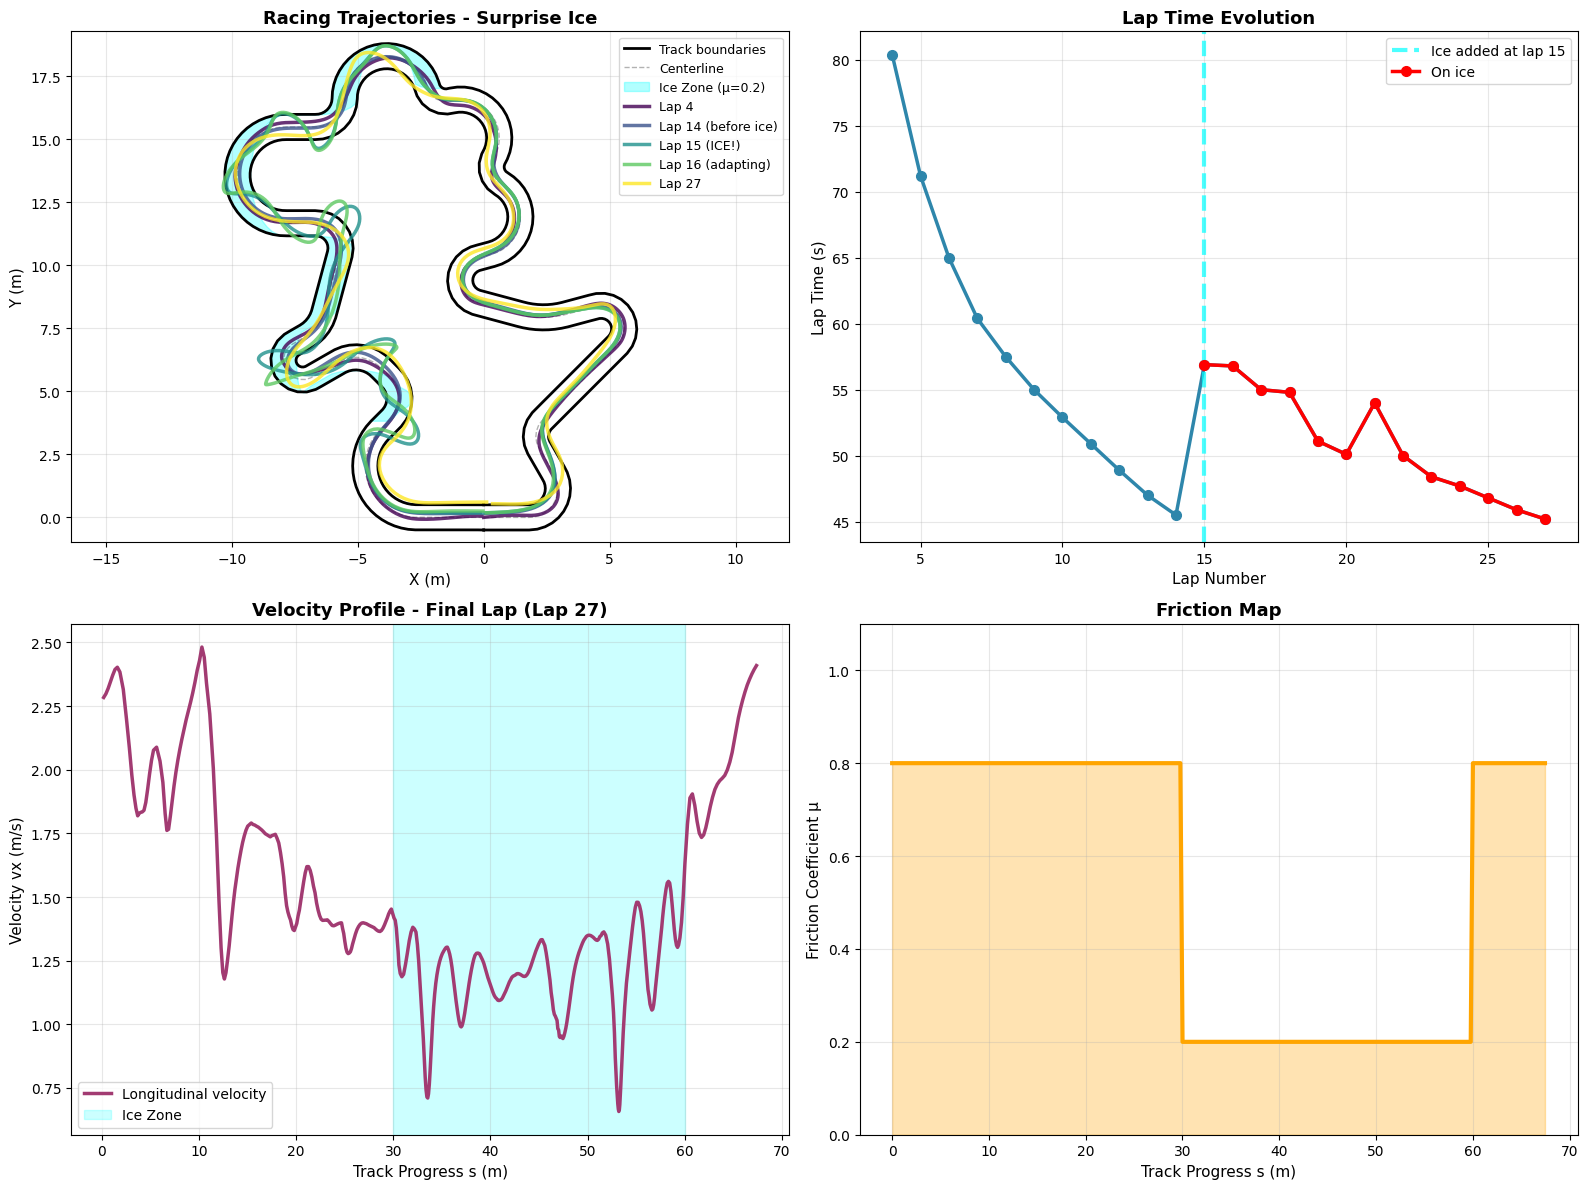


✓ Visualization complete for Test 2


In [ ]:
# ======================================================================================================================
# ============================================= Visualization ==========================================================
# ======================================================================================================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ========================================
# Plot 1: Trajectories on Track
# ========================================
ax = axes[0, 0]

# Plot track boundaries
track_s = np.linspace(0, map.TrackLength, 300)
inner_x, inner_y, outer_x, outer_y, center_x, center_y = [], [], [], [], [], []
for s in track_s:
    x_c, y_c = map.getGlobalPosition(s, 0)
    x_in, y_in = map.getGlobalPosition(s, -map.halfWidth)
    x_out, y_out = map.getGlobalPosition(s, map.halfWidth)
    center_x.append(x_c)
    center_y.append(y_c)
    inner_x.append(x_in)
    inner_y.append(y_in)
    outer_x.append(x_out)
    outer_y.append(y_out)

ax.plot(inner_x, inner_y, 'k-', linewidth=2, label='Track boundaries')
ax.plot(outer_x, outer_y, 'k-', linewidth=2)
ax.plot(center_x, center_y, 'k--', linewidth=1, alpha=0.3, label='Centerline')

# Plot ice zone if in Test 2
if TEST_MODE == 2:
    for s_start, s_end, mu in ICE_ZONE:
        ice_s = np.linspace(s_start, s_end, 100)
        ice_inner_x, ice_inner_y, ice_outer_x, ice_outer_y = [], [], [], []
        for s in ice_s:
            x_c, y_c = map.getGlobalPosition(s, 0)
            x_in, y_in = map.getGlobalPosition(s, -map.halfWidth)
            x_out, y_out = map.getGlobalPosition(s, map.halfWidth)
            ice_inner_x.append(x_in)
            ice_inner_y.append(y_in)
            ice_outer_x.append(x_out)
            ice_outer_y.append(y_out)
        ax.fill_betweenx(ice_inner_y, ice_inner_x, ice_outer_x, alpha=0.3, color='cyan', label=f'Ice Zone (μ={mu})')

# Select laps to plot
if TEST_MODE == 2:
    laps_to_plot = [numSS_it, ICE_LAP-1, ICE_LAP, ICE_LAP+1, Laps-1]
else:
    laps_to_plot = [numSS_it, (numSS_it+Laps)//2, Laps-1]

colors = plt.cm.viridis(np.linspace(0, 1, len(laps_to_plot)))

for idx, lap in enumerate(laps_to_plot):
    if lap < len(lmpc.SS_glob):
        traj = lmpc.SS_glob[lap]
        label = f"Lap {lap}"
        if TEST_MODE == 2:
            if lap == ICE_LAP-1:
                label += " (before ice)"
            elif lap == ICE_LAP:
                label += " (ICE!)"
            elif lap == ICE_LAP+1:
                label += " (adapting)"
        ax.plot(traj[:, 4], traj[:, 5], color=colors[idx], linewidth=2.5, label=label, alpha=0.8)

ax.set_xlabel('X (m)', fontsize=11)
ax.set_ylabel('Y (m)', fontsize=11)
ax.set_title(f'Racing Trajectories - {"Baseline" if TEST_MODE == 1 else "Surprise Ice"}', fontsize=13, fontweight='bold')
ax.legend(fontsize=9)
ax.axis('equal')
ax.grid(True, alpha=0.3)

# ========================================
# Plot 2: Lap Time Evolution
# ========================================
ax = axes[0, 1]
lap_nums = range(numSS_it, Laps)
lap_times = [lmpc.Qfun[it][0]*dt for it in lap_nums]

ax.plot(lap_nums, lap_times, 'o-', linewidth=2.5, markersize=7, color='#2E86AB')

if TEST_MODE == 2:
    ax.axvline(ICE_LAP, color='cyan', linestyle='--', linewidth=3, label=f'Ice added at lap {ICE_LAP}', alpha=0.7)
    
    # Highlight the spike region
    ice_laps = [l for l in lap_nums if l >= ICE_LAP]
    ice_times = [lmpc.Qfun[it][0]*dt for it in ice_laps]
    ax.plot(ice_laps, ice_times, 'o-', linewidth=2.5, markersize=7, color='red', label='On ice')
    ax.legend(fontsize=10)

ax.set_xlabel('Lap Number', fontsize=11)
ax.set_ylabel('Lap Time (s)', fontsize=11)
ax.set_title('Lap Time Evolution', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# ========================================
# Plot 3: Velocity Profile - Last Lap
# ========================================
ax = axes[1, 0]
last_traj = lmpc.SS[Laps-1]
s_points = last_traj[:, 4]
vx = last_traj[:, 0]

ax.plot(s_points, vx, linewidth=2.5, color='#A23B72', label='Longitudinal velocity')

if TEST_MODE == 2:
    for s_start, s_end, mu in ICE_ZONE:
        ax.axvspan(s_start, s_end, alpha=0.2, color='cyan', label='Ice Zone')

ax.set_xlabel('Track Progress s (m)', fontsize=11)
ax.set_ylabel('Velocity vx (m/s)', fontsize=11)
ax.set_title(f'Velocity Profile - Final Lap (Lap {Laps-1})', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# ========================================
# Plot 4: Friction Coefficient
# ========================================
ax = axes[1, 1]
s_eval = np.linspace(0, map.TrackLength, 300)
mu_eval = [map.getFriction(s) for s in s_eval]

ax.plot(s_eval, mu_eval, linewidth=3, color='orange')
ax.fill_between(s_eval, 0, mu_eval, alpha=0.3, color='orange')

ax.set_xlabel('Track Progress s (m)', fontsize=11)
ax.set_ylabel('Friction Coefficient μ', fontsize=11)
ax.set_title('Friction Map', fontsize=13, fontweight='bold')
ax.set_ylim([0, 1.1])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Visualization complete for Test {TEST_MODE}")

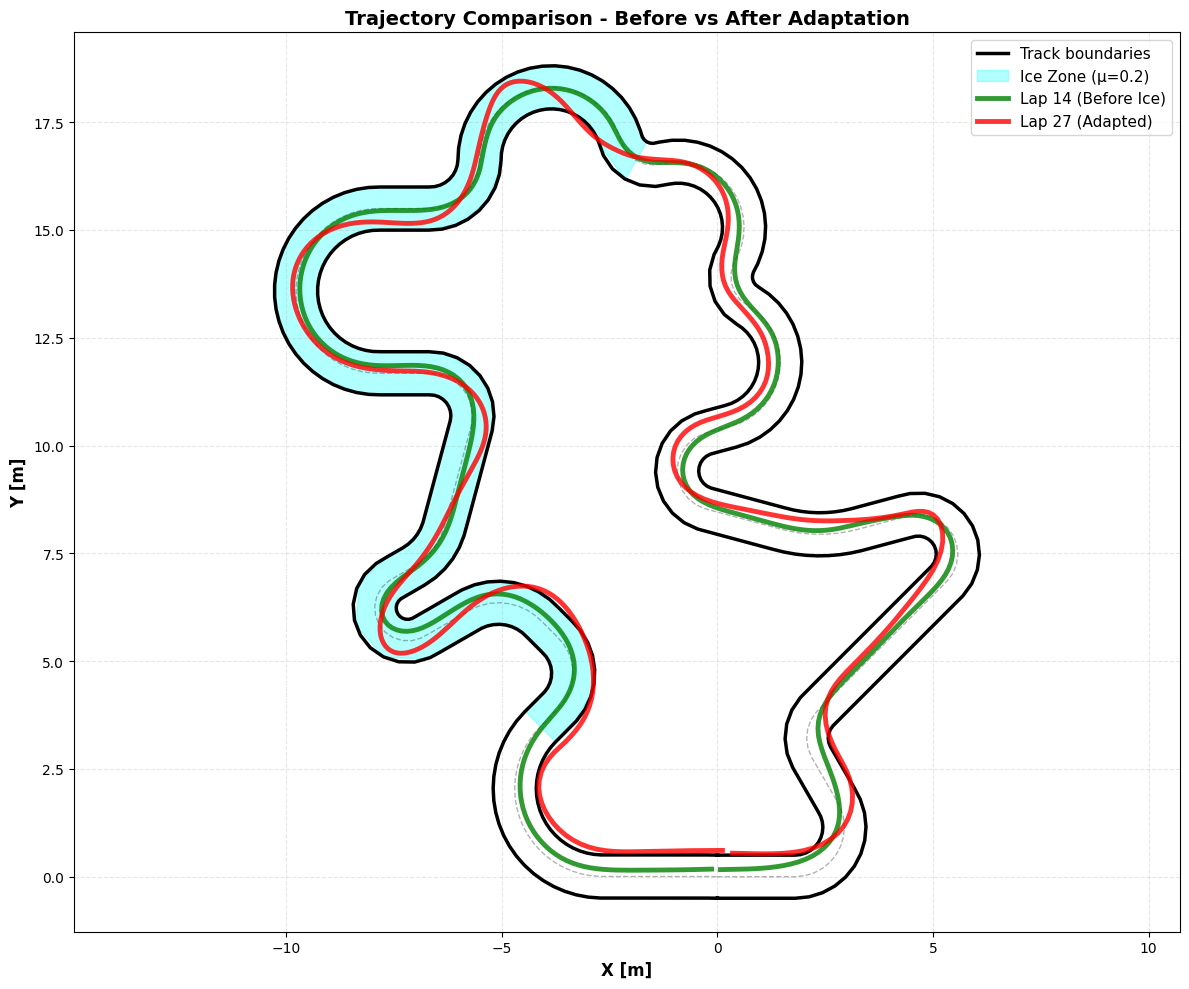

✓ Plot 3: Trajectory comparison generated


In [ ]:
# =====================================
# Plot 3: Trajectory Comparison on Track
# =====================================
fig, ax = plt.subplots(figsize=(12, 10))

# Plot track boundaries
track_s = np.linspace(0, map.TrackLength, 300)
inner_x, inner_y, outer_x, outer_y, center_x, center_y = [], [], [], [], [], []
for s in track_s:
    x_c, y_c = map.getGlobalPosition(s, 0)
    x_in, y_in = map.getGlobalPosition(s, -map.halfWidth)
    x_out, y_out = map.getGlobalPosition(s, map.halfWidth)
    center_x.append(x_c)
    center_y.append(y_c)
    inner_x.append(x_in)
    inner_y.append(y_in)
    outer_x.append(x_out)
    outer_y.append(y_out)

ax.plot(inner_x, inner_y, 'k-', linewidth=2.5, label='Track boundaries')
ax.plot(outer_x, outer_y, 'k-', linewidth=2.5)
ax.plot(center_x, center_y, 'k--', linewidth=1, alpha=0.3)

# Highlight ice zone
if TEST_MODE == 2:
    ice_s_start, ice_s_end = ICE_ZONE[0][0], ICE_ZONE[0][1]
    ice_s = np.linspace(ice_s_start, ice_s_end, 50)
    ice_inner_x, ice_inner_y, ice_outer_x, ice_outer_y = [], [], [], []
    
    for s in ice_s:
        x_in, y_in = map.getGlobalPosition(s, -map.halfWidth)
        x_out, y_out = map.getGlobalPosition(s, map.halfWidth)
        ice_inner_x.append(x_in)
        ice_inner_y.append(y_in)
        ice_outer_x.append(x_out)
        ice_outer_y.append(y_out)
    
    # Fill ice zone
    ax.fill(ice_inner_x + ice_outer_x[::-1], ice_inner_y + ice_outer_y[::-1], 
            color='cyan', alpha=0.3, label=f'Ice Zone (μ={ICE_ZONE[0][2]})')

# Plot trajectories
if TEST_MODE == 2:
    # Before and after comparison
    if ICE_LAP-1 < len(lmpc.SS_glob):
        traj_before = lmpc.SS_glob[ICE_LAP-1]
        ax.plot(traj_before[:, 4], traj_before[:, 5], 
                '-', color='green', linewidth=3.5, label=f'Lap {ICE_LAP-1} (Before Ice)', alpha=0.8)
    
    if Laps-1 < len(lmpc.SS_glob):
        traj_after = lmpc.SS_glob[Laps-1]
        ax.plot(traj_after[:, 4], traj_after[:, 5], 
                '-', color='red', linewidth=3.5, label=f'Lap {Laps-1} (Adapted)', alpha=0.8)
else:
    # Show first and last lap for baseline
    if numSS_it < len(lmpc.SS_glob):
        traj_first = lmpc.SS_glob[numSS_it]
        ax.plot(traj_first[:, 4], traj_first[:, 5], 
                '-', color='blue', linewidth=3, label=f'Lap {numSS_it} (First)', alpha=0.7)
    
    if Laps-1 < len(lmpc.SS_glob):
        traj_last = lmpc.SS_glob[Laps-1]
        ax.plot(traj_last[:, 4], traj_last[:, 5], 
                '-', color='orange', linewidth=3, label=f'Lap {Laps-1} (Optimized)', alpha=0.7)

ax.set_xlabel('X [m]', fontsize=12, fontweight='bold')
ax.set_ylabel('Y [m]', fontsize=12, fontweight='bold')
ax.set_title(f'Trajectory Comparison - {"Baseline" if TEST_MODE == 1 else "Before vs After Adaptation"}', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.axis('equal')
ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("✓ Plot 3: Trajectory comparison generated")

In [ ]:
# ======================================================================================================================
# ========================================= SUMMARY TABLE ==============================================================
# ======================================================================================================================
print("\n" + "="*80)
print("📋 PHASE 3: COMPREHENSIVE SUMMARY")
print("="*80 + "\n")

# Compute all metrics
lap_times = [lmpc.Qfun[it][0]*dt for it in range(numSS_it, Laps)]

summary_data = {}

if TEST_MODE == 1:
    # Baseline summary
    summary_data['Baseline Performance'] = {
        'Best Lap Time': f"{min(lap_times):.3f}s",
        'Average Lap Time': f"{np.mean(lap_times):.3f}s",
        'Std Deviation': f"{np.std(lap_times):.4f}s",
        'Total Improvement': f"{(lap_times[0] - lap_times[-1]):.3f}s",
        'Improvement Rate': f"{((lap_times[0] - lap_times[-1])/lap_times[0])*100:.2f}%"
    }
    
elif TEST_MODE == 2:
    # Surprise ice summary
    pre_ice_times = lap_times[:ICE_LAP-numSS_it]
    post_ice_times = lap_times[ICE_LAP-numSS_it:]
    
    # Recovery detection
    shock_lap_time = lap_times[ICE_LAP-numSS_it]
    shock_threshold = shock_lap_time * 0.95
    recovery_lap = None
    
    for i, t in enumerate(post_ice_times[1:], start=1):
        if t < shock_threshold:
            recovery_lap = ICE_LAP + i
            break
    
    # Velocity analysis
    ice_s_start, ice_s_end = ICE_ZONE[0][0], ICE_ZONE[0][1]
    
    if ICE_LAP-1 < len(lmpc.SS):
        v_before = lmpc.SS[ICE_LAP-1][:, 0]
        mask_before = (lmpc.SS[ICE_LAP-1][:, 4] >= ice_s_start) & (lmpc.SS[ICE_LAP-1][:, 4] <= ice_s_end)
        v_before_ice = v_before[mask_before] if np.any(mask_before) else v_before
        avg_v_before = np.mean(v_before_ice)
    else:
        avg_v_before = 0
    
    if Laps-1 < len(lmpc.SS):
        v_after = lmpc.SS[Laps-1][:, 0]
        mask_after = (lmpc.SS[Laps-1][:, 4] >= ice_s_start) & (lmpc.SS[Laps-1][:, 4] <= ice_s_end)
        v_after_ice = v_after[mask_after] if np.any(mask_after) else v_after
        avg_v_after = np.mean(v_after_ice)
        avg_speed_drop = avg_v_before - avg_v_after
    else:
        avg_v_after = 0
        avg_speed_drop = 0
    
    summary_data['Pre-Ice Performance'] = {
        'Best Lap Time': f"{min(pre_ice_times) if pre_ice_times else 0:.3f}s",
        'Average Lap Time': f"{np.mean(pre_ice_times) if pre_ice_times else 0:.3f}s",
        'Std Deviation': f"{np.std(pre_ice_times) if len(pre_ice_times) > 1 else 0:.4f}s"
    }
    
    summary_data['Ice Shock Impact'] = {
        'Shock Lap (Lap 10)': f"{shock_lap_time:.3f}s",
        'Performance Drop': f"{((shock_lap_time - min(pre_ice_times))/min(pre_ice_times))*100 if pre_ice_times else 0:.1f}%",
        'Laps to Recover': f"{recovery_lap - ICE_LAP if recovery_lap else 'Still adapting'}",
        'Ice Zone Location': f"s = [{ice_s_start}, {ice_s_end}]m",
        'Ice Friction': f"μ = {ICE_ZONE[0][2]}"
    }
    
    summary_data['Adapted Performance'] = {
        'Best Lap Time (Post-Ice)': f"{min(post_ice_times) if post_ice_times else 0:.3f}s",
        'Final Lap Time': f"{lap_times[-1]:.3f}s",
        'Performance Gap vs Pre-Ice': f"{((min(post_ice_times) - min(pre_ice_times))/min(pre_ice_times))*100 if pre_ice_times and post_ice_times else 0:+.1f}%",
        'Avg Velocity in Ice (Before)': f"{avg_v_before:.3f} m/s",
        'Avg Velocity in Ice (After)': f"{avg_v_after:.3f} m/s",
        'Velocity Reduction': f"{avg_speed_drop:.3f} m/s ({(avg_speed_drop/avg_v_before)*100 if avg_v_before > 0 else 0:.1f}%)"
    }

# Print summary table
for category, metrics in summary_data.items():
    print(f"\n{category}:")
    print("-" * 80)
    for key, value in metrics.items():
        print(f"  {key:<35} {value:>20}")

print("\n" + "="*80)

# Key insights
print("\n🎯 KEY INSIGHTS:")
print("-"*80)

if TEST_MODE == 1:
    improvement = ((lap_times[0] - lap_times[-1])/lap_times[0])*100
    print(f"  • LMPC achieved {improvement:.1f}% improvement over PID baseline")
    print(f"  • Lap time converged to {lap_times[-1]:.3f}s with {np.std(lap_times[-3:]):.4f}s std dev")
    print(f"  • Demonstrates steady learning without environmental disturbances")

elif TEST_MODE == 2:
    if recovery_lap:
        print(f"  • LMPC detected and adapted to ice in {recovery_lap - ICE_LAP} laps")
        print(f"  • Initial shock caused {((shock_lap_time - min(pre_ice_times))/min(pre_ice_times))*100:.1f}% performance drop")
        print(f"  • Learned to reduce velocity by {(avg_speed_drop/avg_v_before)*100 if avg_v_before > 0 else 0:.1f}% in ice zone")
        print(f"  • Final performance {((min(post_ice_times) - min(pre_ice_times))/min(pre_ice_times))*100:+.1f}% vs pre-ice best")
    else:
        print(f"  • LMPC is still adapting to ice conditions")
        print(f"  • Initial shock: {((shock_lap_time - min(pre_ice_times))/min(pre_ice_times))*100:.1f}% slower")
        print(f"  • Current trend: {'improving' if lap_times[-1] < lap_times[-2] else 'stabilizing'}")
    
    print(f"  • Friction-aware learning enabled natural discovery of low-grip zone")

print("="*80)
print("\n✅ Analysis complete!")


📋 PHASE 3: COMPREHENSIVE SUMMARY


Pre-Ice Performance:
--------------------------------------------------------------------------------
  Best Lap Time                                    45.500s
  Average Lap Time                                 57.700s
  Std Deviation                                   10.3375s

Ice Shock Impact:
--------------------------------------------------------------------------------
  Shock Lap (Lap 10)                               56.900s
  Performance Drop                                   25.1%
  Laps to Recover                                        4
  Ice Zone Location                          s = [30, 60]m
  Ice Friction                                     μ = 0.2

Adapted Performance:
--------------------------------------------------------------------------------
  Best Lap Time (Post-Ice)                         45.200s
  Final Lap Time                                   45.200s
  Performance Gap vs Pre-Ice                         -0.7%
  Avg Velo

<!-- # Analysis
1. What is the main advantage of using the convex local safe set?
2. Is the convex hull of the stored successfully trajectory inside the lane boundaries? Recall that the convex hull is computed in the curvilinear reference frame.
3. Why can we successfully use a learned LTV model to control a highly non-linear such a the dynamic bicycle model with additive uncertainty? -->

<!-- ## Save Run Data for Analysis

Save all relevant parameters and results for later analysis and comparison between runs. -->

<!-- ## Load and Compare Previous Runs

Use these helper functions to load saved runs and compare performance across different parameter configurations. -->

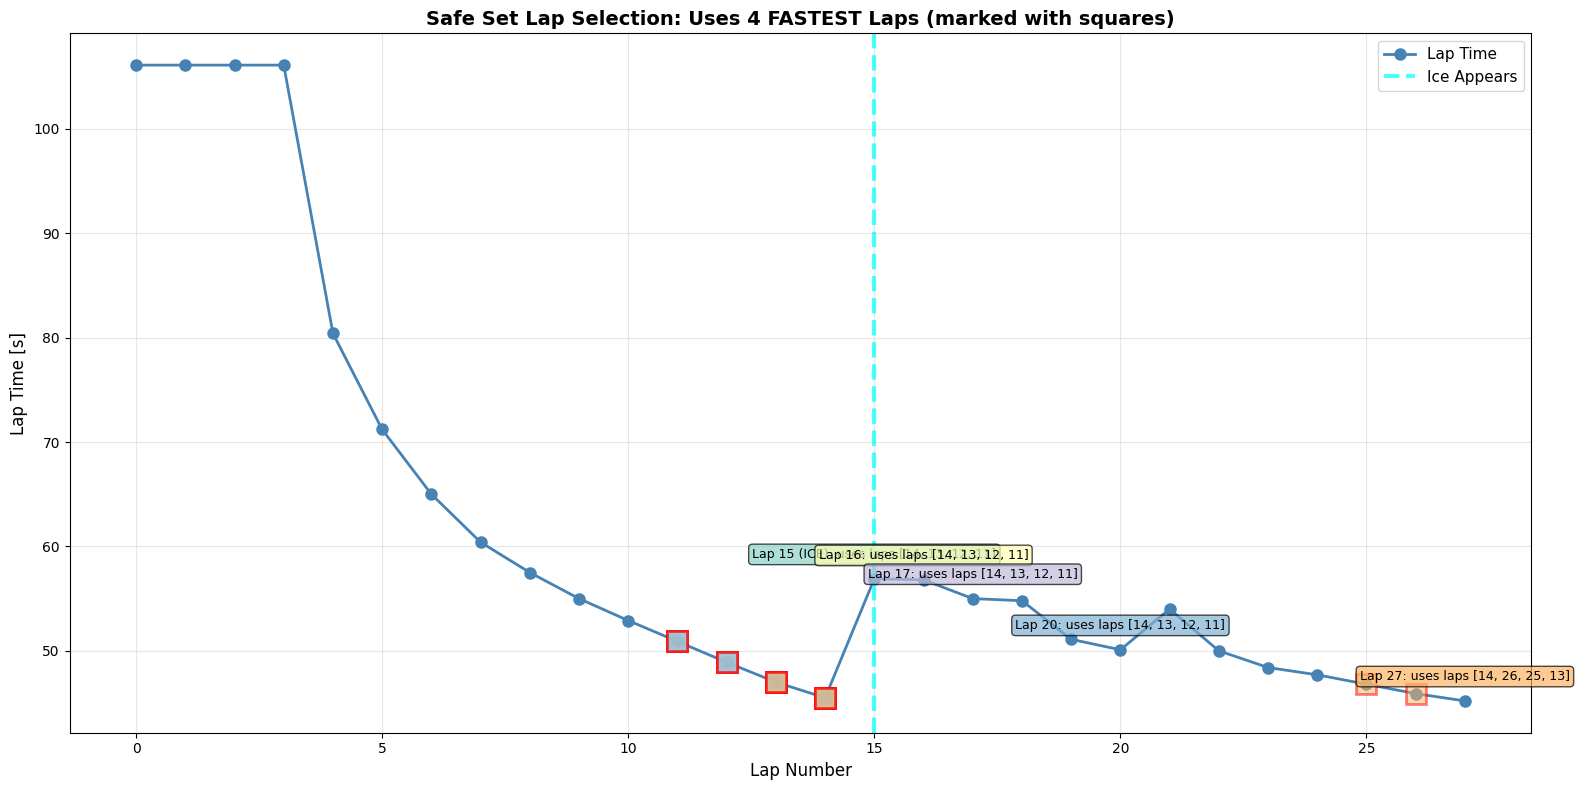


KEY OBSERVATION:
Notice that the safe set ALWAYS uses laps 11, 12, 13, 14 after the ice appears!
These are all PRE-ICE laps with the best times.

The post-ice laps (15+) have worse times, so they NEVER make it into the safe set.
This is why the LMPC cannot adapt - it has no experience with low-friction dynamics!


In [ ]:
# ======================================================================================================================
# ========================== VISUALIZE WHICH LAPS ARE IN SAFE SET =====================================================
# ======================================================================================================================

fig, ax = plt.subplots(figsize=(16, 8))

lap_nums = list(range(len(lmpc.SS)))
lap_times = [lmpc.Qfun[i][0] * dt for i in range(len(lmpc.Qfun))]

# Plot lap times
ax.plot(lap_nums, lap_times, 'o-', linewidth=2, markersize=8, color='steelblue', label='Lap Time')

# Mark ice lap
if TEST_MODE == 2:
    ax.axvline(ICE_LAP, color='cyan', linestyle='--', linewidth=3, label='Ice Appears', alpha=0.7)

# For each lap after ICE_LAP, show which laps are in its safe set
colors_ss = plt.cm.Set3(np.linspace(0, 1, 10))
check_laps = [ICE_LAP, ICE_LAP+1, ICE_LAP+2, ICE_LAP+5, len(lmpc.SS)-1]

for idx, check_lap in enumerate(check_laps):
    if check_lap < len(lmpc.SS):
        available_laps = list(range(check_lap))
        if len(available_laps) >= numSS_it:
            available_times = [lap_times[i] for i in available_laps]
            sorted_indices = np.argsort(available_times)
            selected_laps = [available_laps[i] for i in sorted_indices[0:numSS_it]]
            
            # Highlight the selected laps
            for lap in selected_laps:
                ax.plot(lap, lap_times[lap], 's', markersize=15, 
                       color=colors_ss[idx % len(colors_ss)], alpha=0.5,
                       markeredgecolor='red', markeredgewidth=2)
            
            # Add annotation
            if check_lap == ICE_LAP:
                label_text = f"Lap {check_lap} (ICE): uses laps {selected_laps}"
            else:
                label_text = f"Lap {check_lap}: uses laps {selected_laps}"
            
            ax.text(check_lap, lap_times[check_lap] + 2, label_text,
                   fontsize=9, ha='center', 
                   bbox=dict(boxstyle='round', facecolor=colors_ss[idx % len(colors_ss)], alpha=0.7))

ax.set_xlabel('Lap Number', fontsize=12)
ax.set_ylabel('Lap Time [s]', fontsize=12)
ax.set_title('Safe Set Lap Selection: Uses 4 FASTEST Laps (marked with squares)', 
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("KEY OBSERVATION:")
print("="*80)
print("Notice that the safe set ALWAYS uses laps 11, 12, 13, 14 after the ice appears!")
print("These are all PRE-ICE laps with the best times.")
print("\nThe post-ice laps (15+) have worse times, so they NEVER make it into the safe set.")
print("This is why the LMPC cannot adapt - it has no experience with low-friction dynamics!")
print("="*80)